## 1. Web Scraping the School Districts in Texas

In [203]:
import requests
import re
import patsy
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from helper_fxns import *
from bs4 import BeautifulSoup

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression,Ridge, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
url = "https://ballotpedia.org/List_of_school_districts_in_Texas"

response = requests.get(url)
response.status_code

page = response.text
soup = BeautifulSoup(page)

lst_of_links = list(soup.find_all('a'))
lst_of_links[0:5]

[<a class="btn-block btn-lg btn-primary" href="https://www.facebook.com/sharer/sharer.php?u=https%3A%2F%2Fballotpedia.org%2FList_of_school_districts_in_Texas" target="_blank"><span class="fa fa-facebook"></span>   Share this page</a>,
 <a class="btn-block btn-lg btn-primary" href="https://www.facebook.com/Ballotpedia/" target="_blank"><span class="fa fa-facebook"></span>   Follow Ballotpedia</a>,
 <a class="btn-block btn-lg btn-info" href="https://twitter.com/home?status=https%3A%2F%2Fballotpedia.org%2FList_of_school_districts_in_Texas" target="_blank"><span class="fa fa-twitter"></span>   Share this page</a>,
 <a class="btn-block btn-lg btn-info" href="https://twitter.com/Ballotpedia/" target="_blank"><span class="fa fa-twitter"></span>   Follow Ballotpedia</a>,
 <a data-target="#modal-email" data-toggle="modal" href="#" id="bp-header-email-toggle"><span class="glyphicon glyphicon-envelope"></span><span class="hide-mobile-2"> Subscribe</span></a>]

In [3]:
#compile regex to find all instances of strings with "Texas"
texas_regex = re.compile('Texas')
tx_strs = soup.find_all(text=texas_regex)

In [4]:
#get first and last indices to slice list
#remove texas and commas and CISD, ISD, and CSD from the strings
start_index = tx_strs.index('Abbott Independent School District, Texas')
end_index = tx_strs.index('Zephyr Independent School District, Texas')
tx_strs = tx_strs[start_index : end_index + 1]
for i,district in enumerate(tx_strs):
    tx_strs[i] = tx_strs[i].replace(',','').replace(' Texas', '').\
    replace(' Independent School District','').replace(' Consolidated','').\
    replace(' Common School District', '')
tx_strs[0:5]

['Abbott', 'Abernathy', 'Abilene', 'Academy', 'Adrian']

In [5]:
len(tx_strs)

1010

## 2. Creating School District DataFrame

In [6]:
sd_df = pd.DataFrame({'School District':tx_strs})
sd_df.head()

School District
0          Abbott
1       Abernathy
2         Abilene
3         Academy
4          Adrian

### Merging CSVs, Excel files, and txt files into DataFrame

In [7]:
sat_df = pd.read_csv('./sat_district_data_class_2016.csv',header= 0, names=['Group','District Number','District', 'County', '2016 class SAT mean'],\
                     usecols = [0,1,2,4,10])


In [8]:
#filter for Group == to All Students to remove subsets of students
is_all_students = sat_df['Group'] =='All Students'
sat_df = sat_df[is_all_students]
sat_df['District Number'] = sat_df['District Number'].str.replace('=','').str.replace('"', '').astype(int)
sat_df.head()

Group  District Number       District           County  \
0    All Students             1902     Cayuga ISD  Anderson County   
42   All Students             1903    Elkhart ISD  Anderson County   
84   All Students             1904  Frankston ISD  Anderson County   
126  All Students             1906     Neches ISD  Anderson County   
168  All Students             1907  Palestine ISD  Anderson County   

     2016 class SAT mean  
0                  978.0  
42                 978.0  
84                 932.0  
126                971.0  
168                918.0

In [9]:
#drop Group col
#filter for only public school district aka ISD or CISD
#remove CISD or ISD from District names in District col
#filter for rows with non null SAT vals
#join the sat df with the school district names df
#remove any nulls and duplicates
sat_df.drop('Group', axis =1, inplace= True)
sat_df = get_public_school_dis(sat_df, 'District')
sat_df = remove_cisd_isd_from_col(sat_df, 'District')
sat_df.sort_values(by=['District'], inplace=True)
not_is_nan_sat = sat_df['2016 class SAT mean'].notna()
sat_df = sat_df[not_is_nan_sat]
sat_df = sat_df.set_index('District').join(sd_df.set_index('School District'))
sat_df.dropna(axis=0, how='any', inplace= True)
sat_df.reset_index(inplace=True)
sat_df = sat_df.rename(columns={'index': 'School District'})
sat_df = sat_df.groupby(['District Number','School District','County']).agg('mean')
sat_df.reset_index(inplace=True)
sat_df.head()

District Number School District           County  2016 class SAT mean
0             1902          Cayuga  Anderson County                978.0
1             1903         Elkhart  Anderson County                978.0
2             1904       Frankston  Anderson County                932.0
3             1906          Neches  Anderson County                971.0
4             1907       Palestine  Anderson County                918.0

In [10]:
# #filter for only public school district aka ISD or CISD
# sat_df = get_public_school_dis(sat_df, 'District')
# sat_df.head()

In [11]:
# #filter for rows with non null SAT vals
# sat_df.sort_values(by=['District'], inplace=True)
# not_is_nan_sat = sat_df['2016 class SAT mean'].notna()
# sat_df = sat_df[not_is_nan_sat] #.loc[:,:]
# sat_df.head()

In [12]:
# #join the sat df with the school district names df
# sat_df = sat_df.set_index('District').join(sd_df.set_index('School District'))
# sat_df.head()

In [13]:
# #remove any nulls
# sat_df.dropna(axis=0, how='any', inplace= True)
# sat_df.reset_index(inplace=True)
# sat_df = sat_df.rename(columns={'index': 'School District'})
# sat_df.head()


In [14]:
#

In [15]:
#join 2014-2015 funding excel into sat_df
funds_df = pd.read_excel('./Total Operating Expenditures 2006-2017.xlsx', header = 1,names=['District Number',\
            'School District', 'Expenditures per Student'],usecols = [0,1,31], nrows=1308)
funds_df.head()

District Number School District  Expenditures per Student
0             1902      CAYUGA ISD                   14278.0
1             1903     ELKHART ISD                    8509.0
2             1904   FRANKSTON ISD                    8994.0
3             1906      NECHES ISD                   10349.0
4             1907   PALESTINE ISD                   10021.0

In [16]:
#filter for only public schools and remove CISD or ISD from names
funds_df = get_public_school_dis(funds_df, 'School District')
remove_cisd_isd_from_col(funds_df, 'School District')
funds_df.head()

District Number School District  Expenditures per Student
0             1902          CAYUGA                   14278.0
1             1903         ELKHART                    8509.0
2             1904       FRANKSTON                    8994.0
3             1906          NECHES                   10349.0
4             1907       PALESTINE                   10021.0

In [17]:
#check for duplicates
print(sum(funds_df.duplicated(keep=False) == True))

#Modify School District strings to first characters of all the words capitalized
funds_df['School District'] = funds_df['School District'].str.title()
funds_df.head()

0


District Number School District  Expenditures per Student
0             1902          Cayuga                   14278.0
1             1903         Elkhart                    8509.0
2             1904       Frankston                    8994.0
3             1906          Neches                   10349.0
4             1907       Palestine                   10021.0

In [18]:
#join funds_df with the sat_df
#sat_df = sat_df.set_index('School District').join(funds_df.set_index('School District') on='School District', 'District Number'
sat_df = sat_df.merge(funds_df, on=('School District', 'District Number'))
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 793
Data columns (total 5 columns):
District Number             794 non-null int64
School District             794 non-null object
County                      794 non-null object
2016 class SAT mean         794 non-null float64
Expenditures per Student    794 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 37.2+ KB


In [19]:
#sat_df.reset_index(inplace=True)
sat_df.head()

District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  
0                   14278.0  
1                    8509.0  
2                    8994.0  
3                   10349.0  
4                   10021.0

In [20]:
null_columns=sat_df.columns[sat_df.isnull().any()]
print(sat_df[sat_df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [21]:
#get rid of duplicates by averaging them and reset the index
#sat_df = sat_df.groupby(['School District','County', '2016 class SAT mean']).agg('mean')


In [22]:
#remove nulls and reset index

#sat_df.dropna(axis=0, how='any', inplace= True)
#sat_df.reset_index(inplace=True)

In [23]:
print(sat_df.head())
sat_df.info()

   District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  
0                   14278.0  
1                    8509.0  
2                    8994.0  
3                   10349.0  
4                   10021.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 793
Data columns (total 5 columns):
District Number             794 non-null int64
School District             794 non-null object
County                      794 non-null object
2016 class SAT mean         794 non-null float64
Expenditures per Student    794 non-null float64
dtypes: float64(2)

In [24]:
#join 2014-2015 economically disadvantaged count csv into sat_df
econ_dis_df = pd.read_csv('./Economically Disadvantaged Report_Statewide_Districts_2014-2015.csv', header = 2,\
                            usecols = [2,3,5,7,9]) #names=['School District', 'Not Economically Disadvantaged Student Count']
econ_dis_df.head()

District Name   District Number  \
0   A W BROWN-FELLOWSHIP LEADERSHIP AC             57816   
1                           A+ ACADEMY             57829   
2                           ABBOTT ISD            109901   
3                        ABERNATHY ISD             95901   
4                          ABILENE ISD            221901   

    Eligible For Free Meals Count   Eligible For Reduced-Price Meals Count  \
0                            1419                                      402   
1                             804                                      110   
2                              38                                       21   
3                             343                                       76   
4                            9228                                     1692   

    Other Economically Disadvantaged Count  
0                                        0  
1                                        0  
2                                        0  
3                                        0  
4                                       49

In [25]:
econ_dis_df.columns = econ_dis_df.columns.str.strip()

In [26]:
#remove negative numbers from df
#remove_neg_nums = econ_dis_df['Economically Disadvantaged Student Count'] >= 0
#econ_dis_df = econ_dis_df[remove_neg_nums]
#econ_dis_df.reset_index(drop=True, inplace=True)

econ_dis_df = econ_dis_df.replace(-9999999,0)
econ_dis_df.head()

District Name  District Number  \
0   A W BROWN-FELLOWSHIP LEADERSHIP AC            57816   
1                           A+ ACADEMY            57829   
2                           ABBOTT ISD           109901   
3                        ABERNATHY ISD            95901   
4                          ABILENE ISD           221901   

   Eligible For Free Meals Count  Eligible For Reduced-Price Meals Count  \
0                           1419                                     402   
1                            804                                     110   
2                             38                                      21   
3                            343                                      76   
4                           9228                                    1692   

   Other Economically Disadvantaged Count  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                      49

In [27]:
#get total economically disadvantaged students
econ_dis_df['Economically Disadvantaged Student Count'] = econ_dis_df['Eligible For Free Meals Count']\
+econ_dis_df['Eligible For Reduced-Price Meals Count'] + econ_dis_df['Other Economically Disadvantaged Count']

econ_dis_df.drop(columns=['Eligible For Free Meals Count','Eligible For Reduced-Price Meals Count','Other Economically Disadvantaged Count'], inplace=True)
econ_dis_df.head()

District Name  District Number  \
0   A W BROWN-FELLOWSHIP LEADERSHIP AC            57816   
1                           A+ ACADEMY            57829   
2                           ABBOTT ISD           109901   
3                        ABERNATHY ISD            95901   
4                          ABILENE ISD           221901   

   Economically Disadvantaged Student Count  
0                                      1821  
1                                       914  
2                                        59  
3                                       419  
4                                     10969

In [28]:
econ_dis_df = get_public_school_dis(econ_dis_df, 'District Name')
econ_dis_df = remove_cisd_isd_from_col(econ_dis_df, 'District Name')
econ_dis_df['District Name'] = econ_dis_df['District Name'].str.title().str.strip()
econ_dis_df.head()

District Name  District Number  Economically Disadvantaged Student Count
2         Abbott           109901                                        59
3      Abernathy            95901                                       419
4        Abilene           221901                                     10969
6        Academy            14901                                       538
11        Adrian           180903                                        76

In [29]:
econ_dis_df = econ_dis_df.rename(columns={'District Name': 'School District'})
#sat_df = sat_df.set_index('School District').join(econ_dis_df.set_index('School District'))
sat_df = sat_df.merge(econ_dis_df,on=('School District','District Number'))
#sat_df.reset_index(inplace=True)
sat_df.head()

District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  Economically Disadvantaged Student Count  
0                   14278.0                                       210  
1                    8509.0                                       648  
2                    8994.0                                       446  
3                   10349.0                                       156  
4                   10021.0                                      2458

In [30]:
#check for duplicates
#check for duplicates
#print(sum(sat_df.duplicated() == True))
#sat_df[sat_df.duplicated(subset='District Number')  == True]

In [31]:
#join 2014-2015 average daily attendance excel into sat_df
ada_df = pd.read_excel('./County ADA Report 2005-2018.xlsx', header = 0 ,names=['District Number',\
            'School District','Average Daily Attendance'],usecols = [2,3,12])
ada_df.head()

District Number School District  Average Daily Attendance
0             1902      CAYUGA ISD                   560.125
1             1903     ELKHART ISD                  1134.768
2             1904   FRANKSTON ISD                   713.236
3             1906      NECHES ISD                   396.754
4             1907   PALESTINE ISD                  3052.135

In [32]:
ada_df = get_public_school_dis(ada_df, 'School District')
ada_df = remove_cisd_isd_from_col(ada_df, 'School District')
ada_df['School District'] = ada_df['School District'].str.title()
ada_df.head()

District Number School District  Average Daily Attendance
0             1902          Cayuga                   560.125
1             1903         Elkhart                  1134.768
2             1904       Frankston                   713.236
3             1906          Neches                   396.754
4             1907       Palestine                  3052.135

In [33]:
sat_df = sat_df.merge(ada_df,on=('School District','District Number'))
#sat_df.drop('index', axis = 1, inplace=True)
sat_df.head()

District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  Economically Disadvantaged Student Count  \
0                   14278.0                                       210   
1                    8509.0                                       648   
2                    8994.0                                       446   
3                   10349.0                                       156   
4                   10021.0                                      2458   

   Average Daily Attendance  
0                   560.125  
1                  1134.768  
2                   713.236  
3                   396.754  
4                  3052.135

In [34]:
#join 2014-2015 annual dropout rate excel into sat_df
drop_df = pd.read_excel('./District_Data_Download_Drop.xlsx', sheet_name= "Drop_1415", header = 0,\
                        names=['Calc for state Accountability','Gradespan','District Number',\
                               'School District','Annual Dropout Rate'],usecols = [0,1,2,3,9])
drop_df.head()

Calc for state Accountability  Gradespan  District Number School District  \
0                            No        712             1902      Cayuga ISD   
1                           Yes        712             1902      Cayuga ISD   
2                            No         78             1902      Cayuga ISD   
3                           Yes         78             1902      Cayuga ISD   
4                            No        912             1902      Cayuga ISD   

   Annual Dropout Rate  
0                  1.0  
1                  1.0  
2                  0.0  
3                  0.0  
4                  1.4

In [35]:
#Filter for 7-12 grades and Calculated for State Accountability equal to yes
grade_712 = drop_df['Gradespan'] == 712
state_acct = drop_df['Calc for state Accountability'] == 'Yes'
drop_df = drop_df[grade_712 & state_acct]
drop_df.head()

Calc for state Accountability  Gradespan  District Number School District  \
1                            Yes        712             1902      Cayuga ISD   
7                            Yes        712             1903     Elkhart ISD   
13                           Yes        712             1904   Frankston ISD   
19                           Yes        712             1906      Neches ISD   
25                           Yes        712             1907   Palestine ISD   

    Annual Dropout Rate  
1                   1.0  
7                   0.0  
13                  0.3  
19                  1.0  
25                  0.6

In [36]:
drop_df = get_public_school_dis(drop_df, 'School District')
drop_df = remove_cisd_isd_from_col(drop_df, 'School District')
drop_df.head()

Calc for state Accountability  Gradespan  District Number School District  \
1                            Yes        712             1902          Cayuga   
7                            Yes        712             1903         Elkhart   
13                           Yes        712             1904       Frankston   
19                           Yes        712             1906          Neches   
25                           Yes        712             1907       Palestine   

    Annual Dropout Rate  
1                   1.0  
7                   0.0  
13                  0.3  
19                  1.0  
25                  0.6

In [37]:
drop_df.drop(columns=['Calc for state Accountability', 'Gradespan'], inplace= True)
drop_df.head()

District Number School District  Annual Dropout Rate
1              1902          Cayuga                  1.0
7              1903         Elkhart                  0.0
13             1904       Frankston                  0.3
19             1906          Neches                  1.0
25             1907       Palestine                  0.6

In [38]:
sat_df = sat_df.merge(drop_df,on=('School District','District Number'))
#sat_df.drop('index', axis = 1, inplace=True)
sat_df.head()

District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  Economically Disadvantaged Student Count  \
0                   14278.0                                       210   
1                    8509.0                                       648   
2                    8994.0                                       446   
3                   10349.0                                       156   
4                   10021.0                                      2458   

   Average Daily Attendance  Annual Dropout Rate  
0                   560.125                  1.0  
1                  1134.768                  0.0  
2                   713.236                  0.3  
3                   396.754                  1.0  
4                  3052.135                  0.6

In [39]:
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 8 columns):
District Number                             793 non-null int64
School District                             793 non-null object
County                                      793 non-null object
2016 class SAT mean                         793 non-null float64
Expenditures per Student                    793 non-null float64
Economically Disadvantaged Student Count    793 non-null int64
Average Daily Attendance                    793 non-null float64
Annual Dropout Rate                         793 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 55.8+ KB


In [40]:
#sat_df[sat_df['School District'].duplicated()]

In [41]:
#join LEAID into sat_df in order to link data from nces with data in sat_df

In [42]:
leaid_df = pd.read_excel('./EDGE_GEOCODE_PUBLICLEA_1718.xlsx', header = 0,\
                        names=['LEAID','School District','State','County'],usecols = [0,1,5,9])
leaid_df.head()

LEAID         School District State            County
0  100002  Alabama Youth Services    AL  Jefferson County
1  100005        Albertville City    AL   Marshall County
2  100006         Marshall County    AL   Marshall County
3  100007             Hoover City    AL  Jefferson County
4  100008            Madison City    AL    Madison County

In [43]:
tx_schools = leaid_df['State'] == 'TX'
leaid_df = leaid_df[tx_schools]
leaid_df.head()

LEAID   School District State          County
15763  4800001    CROSBYTON CISD    TX   Crosby County
15764  4800002          SPUR ISD    TX  Dickens County
15765  4800003   ROCKSPRINGS ISD    TX  Edwards County
15766  4800004  POR VIDA ACADEMY    TX    Bexar County
15767  4800005    BLACKWELL CISD    TX    Nolan County

In [44]:
leaid_df.loc[:,'LEAID'] = leaid_df['LEAID'] - 4800000
leaid_df.head()

LEAID   School District State          County
15763      1    CROSBYTON CISD    TX   Crosby County
15764      2          SPUR ISD    TX  Dickens County
15765      3   ROCKSPRINGS ISD    TX  Edwards County
15766      4  POR VIDA ACADEMY    TX    Bexar County
15767      5    BLACKWELL CISD    TX    Nolan County

In [45]:
leaid_df = get_public_school_dis(leaid_df, 'School District')
leaid_df = remove_cisd_isd_from_col(leaid_df, 'School District')
leaid_df['School District'] = leaid_df['School District'].str.title()
leaid_df.head()

LEAID School District State            County
15763      1       Crosbyton    TX     Crosby County
15764      2            Spur    TX    Dickens County
15765      3     Rocksprings    TX    Edwards County
15767      5       Blackwell    TX      Nolan County
15768      6       Aspermont    TX  Stonewall County

In [46]:
leaid_df.reset_index(drop=True, inplace=True)
leaid_df.head()

LEAID School District State            County
0      1       Crosbyton    TX     Crosby County
1      2            Spur    TX    Dickens County
2      3     Rocksprings    TX    Edwards County
3      5       Blackwell    TX      Nolan County
4      6       Aspermont    TX  Stonewall County

In [47]:
sat_df_before_merge_schools = list(sat_df['School District'])
sat_df = sat_df.merge(leaid_df,left_on=('School District','County'), right_on=('School District','County'), how= 'left')
sat_df_after_merge_schools = list(sat_df['School District'])
sat_df.head()

District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  Economically Disadvantaged Student Count  \
0                   14278.0                                       210   
1                    8509.0                                       648   
2                    8994.0                                       446   
3                   10349.0                                       156   
4                   10021.0                                      2458   

   Average Daily Attendance  Annual Dropout Rate    LEAID State  
0                   560.125                  1.0  13200.0    TX  
1                  1134.768                  0.0  18390.0    TX  
2                   713.236                  0.3  19770.0    TX  
3                   396.754                  1.0  32250.0    TX  
4                  3052.135                  0.6  34050.0    TX

In [48]:
#find rows with missing rows
sat_df.head()
#len(set(sat_df_after_merge_schools))
#sat_df.isnull().values.any() #sum()
#sat_df[sat_df['LEAID'] == ]
sat_df[sat_df.isnull().any(axis=1)]

District Number School District            County  2016 class SAT mean  \
66             18904    Valley Mills     Bosque County                981.0   
112            31916     South Texas    Cameron County               1035.0   
165            50909       Jonesboro    Coryell County                933.0   
200            62903          Yoakum     DeWitt County                888.0   
261            84904       La Marque  Galveston County                754.0   
324           101914            Katy     Harris County               1074.0   
408           121902      Brookeland     Jasper County               1053.0   
656           212902         Bullard      Smith County                946.0   

     Expenditures per Student  Economically Disadvantaged Student Count  \
66                     9426.0                                       384   
112                   13464.0                                      1935   
165                    9011.0                                        91   
200                   12460.0                                      1139   
261                   10236.0                                      1592   
324                    8907.0                                     20057   
408                   12131.0                                       243   
656                    8083.0                                       866   

     Average Daily Attendance  Annual Dropout Rate  LEAID State  
66                    573.165                  0.0    NaN   NaN  
112                  3213.220                  0.0    NaN   NaN  
165                   146.361                  0.0    NaN   NaN  
200                  1491.059                  0.1    NaN   NaN  
261                  2445.524                  1.7    NaN   NaN  
324                 61425.623                  0.7    NaN   NaN  
408                   376.254                  0.0    NaN   NaN  
656                  2043.139                  0.3    NaN   NaN

### After further inspection of the missing values, it was determined that they are located in multiple counties, and they are listed under different counties in the two data sets. They are however majorly located in the county listed in the sat_df from the sat score data, so I will manually add their LEAID and STATE to the sat_df where they are currently missing.

In [49]:
sat_df.fillna(value={'State':'TX'}, axis=0, inplace=True)
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 10 columns):
District Number                             793 non-null int64
School District                             793 non-null object
County                                      793 non-null object
2016 class SAT mean                         793 non-null float64
Expenditures per Student                    793 non-null float64
Economically Disadvantaged Student Count    793 non-null int64
Average Daily Attendance                    793 non-null float64
Annual Dropout Rate                         793 non-null float64
LEAID                                       785 non-null float64
State                                       793 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 68.1+ KB


In [50]:
#fills missing LEAIDs with LEAIDs from leaid_df at row with same school district name if found
# or -1 if not found
for i,row in sat_df[sat_df.isnull().any(axis=1)].iterrows():
    index_sat = sat_df.index[sat_df['School District'] == row[1]]
    index_leaid = leaid_df.index[leaid_df['School District'] == row[1]]
    if index_leaid.size == 0:
        value = -1
    else:
        value = leaid_df.iloc[index_leaid[0],0]
    sat_df.iloc[index_sat[0],8] = value

In [51]:
sat_df[sat_df['LEAID'] == -1]
sat_df.info() #same number of values in all rows now

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 10 columns):
District Number                             793 non-null int64
School District                             793 non-null object
County                                      793 non-null object
2016 class SAT mean                         793 non-null float64
Expenditures per Student                    793 non-null float64
Economically Disadvantaged Student Count    793 non-null int64
Average Daily Attendance                    793 non-null float64
Annual Dropout Rate                         793 non-null float64
LEAID                                       793 non-null float64
State                                       793 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 68.1+ KB


In [52]:
sat_df.head()

District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  Economically Disadvantaged Student Count  \
0                   14278.0                                       210   
1                    8509.0                                       648   
2                    8994.0                                       446   
3                   10349.0                                       156   
4                   10021.0                                      2458   

   Average Daily Attendance  Annual Dropout Rate    LEAID State  
0                   560.125                  1.0  13200.0    TX  
1                  1134.768                  0.0  18390.0    TX  
2                   713.236                  0.3  19770.0    TX  
3                   396.754                  1.0  32250.0    TX  
4                  3052.135                  0.6  34050.0    TX

In [53]:
#join 2014-2015 sex and race text into sat_df
sex_race_df = pd.read_table('./CDP05_105_04000US48_105204558448.txt', header= 0, sep= "|",\
                        names=['School District','LEAID','Percent Male','Percent Female',\
                               'Percent White','Percent Black', 'Percent Native American',\
                               'Percent Asian', 'Percent Pacific Islander', 'Percent other race'],usecols = [1,2,9,33,71,75,79,99,131,151])
sex_race_df.head()

School District  LEAID  Percent Male  \
0      Abbott Independent School District, TX   7380          51.0   
1   Abernathy Independent School District, TX   7410          58.4   
2     Abilene Independent School District, TX   7440          51.6   
3     Academy Independent School District, TX   7470          71.7   
4  Agua Dulce Independent School District, TX   7530          37.3   

   Percent Female  Percent White  Percent Black  Percent Native American  \
0            49.0           98.0            0.0                      1.6   
1            41.6           84.5            0.0                      0.0   
2            48.3           68.4           12.7                      0.4   
3            28.3           89.8            3.6                      0.0   
4            62.7           89.8            6.8                      3.4   

   Percent Asian  Percent Pacific Islander  Percent other race  
0            0.0                       0.0                 0.0  
1            0.0                       0.0                 2.5  
2            1.6                       0.0                 9.6  
3            1.2                       0.0                 2.4  
4            0.0                       0.0                 0.0

In [54]:
#try to fill any missing (-1) LEAIDS with values from sex_race_df
for i,row in sat_df[sat_df['LEAID'] == -1].iterrows():
    index_sat = sat_df.index[sat_df['School District'] == row[1]]
    index_sex_race = sex_race_df.index[sex_race_df['School District'] == f"{row[1]} Independent School District, TX"]
    if index_sex_race.size == 0:
        value = -1
    else:
        value = sex_race_df.iloc[index_sex_race[0],1]
    sat_df.iloc[index_sat[0],8] = value
sat_df[sat_df['LEAID'] == -1] #hopefully empty!


Empty DataFrame
Columns: [District Number, School District, County, 2016 class SAT mean, Expenditures per Student, Economically Disadvantaged Student Count, Average Daily Attendance, Annual Dropout Rate, LEAID, State]
Index: []

In [55]:
sex_race_df = remove_cisd_isd_from_col(sex_race_df, 'School District')

#is_isd_cisd = re.compile(r'\s(CISD|ISD|CONSOLIDATED ISD|CONSOLIDATED CISD|Consolidated Independent School District, TX|Independent School District, TX)')
#sex_race_df['School District'] =sex_race_df['School District'].replace(to_replace=is_isd_cisd, value='') 
sex_race_df.head()

School District  LEAID  Percent Male  Percent Female  Percent White  \
0          Abbott   7380          51.0            49.0           98.0   
1       Abernathy   7410          58.4            41.6           84.5   
2         Abilene   7440          51.6            48.3           68.4   
3         Academy   7470          71.7            28.3           89.8   
4      Agua Dulce   7530          37.3            62.7           89.8   

   Percent Black  Percent Native American  Percent Asian  \
0            0.0                      1.6            0.0   
1            0.0                      0.0            0.0   
2           12.7                      0.4            1.6   
3            3.6                      0.0            1.2   
4            6.8                      3.4            0.0   

   Percent Pacific Islander  Percent other race  
0                       0.0                 0.0  
1                       0.0                 2.5  
2                       0.0                 9.6  
3                       0.0                 2.4  
4                       0.0                 0.0

In [56]:
#drop school district from sex_race_df
sex_race_df.drop(columns= 'School District', inplace=True)
sex_race_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 9 columns):
LEAID                       877 non-null int64
Percent Male                877 non-null float64
Percent Female              877 non-null float64
Percent White               877 non-null float64
Percent Black               877 non-null float64
Percent Native American     877 non-null float64
Percent Asian               877 non-null float64
Percent Pacific Islander    877 non-null float64
Percent other race          877 non-null float64
dtypes: float64(8), int64(1)
memory usage: 61.8 KB


In [57]:
sex_race_df['LEAID'] = sex_race_df['LEAID'].astype(float)
sat_df = sat_df.merge(sex_race_df,left_on=('LEAID'), right_on=('LEAID'), how= 'left')
sat_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 18 columns):
District Number                             793 non-null int64
School District                             793 non-null object
County                                      793 non-null object
2016 class SAT mean                         793 non-null float64
Expenditures per Student                    793 non-null float64
Economically Disadvantaged Student Count    793 non-null int64
Average Daily Attendance                    793 non-null float64
Annual Dropout Rate                         793 non-null float64
LEAID                                       793 non-null float64
State                                       793 non-null object
Percent Male                                735 non-null float64
Percent Female                              735 non-null float64
Percent White                               735 non-null float64
Percent Black                               735 non-null 

In [58]:
sat_df.head()
#sat_df['LEAID'] = sat_df['LEAID'].astype(float)
#sat_df.info()
sat_df[sat_df.isnull().any(axis=1)]

District Number    School District                County  \
28             10901             Medina        Bandera County   
62             17901      Borden County         Borden County   
69             18907            Kopperl         Bosque County   
70             18908      Cranfills Gap         Bosque County   
91             25905                May          Brown County   
100            28906        Prairie Lea       Caldwell County   
112            31916        South Texas        Cameron County   
121            36903      East Chambers       Chambers County   
133            42905      Panther Creek        Coleman County   
155            47905             Sidney       Comanche County   
156            48903         Paint Rock         Concho County   
199            62902           Nordheim         DeWitt County   
204            67902              Cisco       Eastland County   
206            67904             Gorman       Eastland County   
210            70901             Avalon          Ellis County   
245            75908  Round Top-Carmine        Fayette County   
260            84903        High Island      Galveston County   
267            85903          Southland          Garza County   
269            86902             Harper      Gillespie County   
298            93905           Richards         Grimes County   
308            99902        Chillicothe       Hardeman County   
367           109912            Aquilla           Hill County   
369           109914           Penelope           Hill County   
374           110908         Whitharral        Hockley County   
405           119903       Perrin-Whitt           Jack County   
408           121902         Brookeland         Jasper County   
411           121906            Evadale         Jasper County   
417           123913        Sabine Pass      Jefferson County   
451           137904    Santa Gertrudis        Kleberg County   
467           144903           Dime Box            Lee County   
507           160905               Lohn      McCulloch County   
539           169910         Forestburg       Montague County   
565           176903         Deweyville         Newton County   
568           177905           Highland          Nolan County   
573           178908       Port Aransas         Nueces County   
579           180901         Boys Ranch         Oldham County   
589           182904              Santo     Palo Pinto County   
590           182905             Strawn     Palo Pinto County   
598           184908            Peaster         Parker County   
600           186901        Buena Vista          Pecos County   
605           187906            Leggett           Polk County   
621           197902              Miami        Roberts County   
622           198901            Bremond      Robertson County   
625           198906            Mumford      Robertson County   
639           203902           Broaddus  San Augustine County   
650           206903           Cherokee       San Saba County   
706           228904        Centerville        Trinity County   
707           228905      Apple Springs        Trinity County   
711           229905            Spurger          Tyler County   
717           230906          New Diana         Upshur County   
719           232901             Knippa         Uvalde County   
722           232904             Utopia         Uvalde County   
724           233903           Comstock      Val Verde County   
740           239903             Burton     Washington County   
743           240904               Webb           Webb County   
744           241901             Boling        Wharton County   
751           243902            Electra        Wichita County   
785           250905             Yantis           Wood County   

     2016 class SAT mean  Expenditures per Student  \
28                 927.0                   12789.0   
62                1020.0                   19898.0   
69     

In [59]:
#for now drop any rows with null. Should look more into these to see why theyre null or try to fix
#school col in sex_race and then merge on school district and Leaid
sat_df.dropna(axis=0, how='any', inplace= True)
sat_df.reset_index(drop=True, inplace=True)

In [60]:
sat_df.head()

District Number School District           County  2016 class SAT mean  \
0             1902          Cayuga  Anderson County                978.0   
1             1903         Elkhart  Anderson County                978.0   
2             1904       Frankston  Anderson County                932.0   
3             1906          Neches  Anderson County                971.0   
4             1907       Palestine  Anderson County                918.0   

   Expenditures per Student  Economically Disadvantaged Student Count  \
0                   14278.0                                       210   
1                    8509.0                                       648   
2                    8994.0                                       446   
3                   10349.0                                       156   
4                   10021.0                                      2458   

   Average Daily Attendance  Annual Dropout Rate    LEAID State  Percent Male  \
0                   560.125                  1.0  13200.0    TX          67.3   
1                  1134.768                  0.0  18390.0    TX          55.3   
2                   713.236                  0.3  19770.0    TX          43.9   
3                   396.754                  1.0  32250.0    TX          65.0   
4                  3052.135                  0.6  34050.0    TX          45.5   

   Percent Female  Percent White  Percent Black  Percent Native American  \
0            33.6           81.4           18.6                      0.0   
1            44.7           97.0            1.1                      0.0   
2            56.1           63.5           18.2                      0.0   
3            35.0           82.5           17.5                      0.0   
4            54.5           64.1           25.7                      0.0   

   Percent Asian  Percent Pacific Islander  Percent other race  
0            0.0                       0.0                 0.0  
1            0.0                       0.0                 0.0  
2            1.4                       0.0                 9.5  
3            0.0                       0.0                 0.0  
4            1.0                       0.0                 4.3

In [61]:
#join 2010-2014 parental information text into sat_df
education_df = pd.read_table('./PDP02.5_205_04000US48_1071448307.txt', header= 0, sep= "|",\
                        names=['School District','LEAID','% Less than 9th Grade','% High School No diploma',\
                               '% High School Diploma','% Some College No Degree', "% Associate's Degree",\
                               "% Bachelor's Degree", '% Graduate or Professional Degree'],usecols = [1,2,9,13,17,21,25,29,33])
education_df.head()

School District  LEAID  % Less than 9th Grade  \
0      Abbott Independent School District, TX   7380                    1.8   
1   Abernathy Independent School District, TX   7410                    4.1   
2     Abilene Independent School District, TX   7440                    6.1   
3     Academy Independent School District, TX   7470                    4.3   
4  Agua Dulce Independent School District, TX   7530                    5.8   

   % High School No diploma  % High School Diploma  % Some College No Degree  \
0                       0.0                   29.5                      20.5   
1                      15.6                   34.0                      21.1   
2                      10.4                   26.0                      30.5   
3                       0.6                   30.5                      31.9   
4                       7.7                   28.8                      21.2   

   % Associate's Degree  % Bachelor's Degree  \
0                  20.5                 22.7   
1                   2.7                 10.2   
2                   7.6                 13.4   
3                  12.1                  9.2   
4                  15.4                 11.5   

   % Graduate or Professional Degree  
0                                6.8  
1                               12.2  
2                                6.0  
3                               10.6  
4                                7.7

In [62]:
#education_df = remove_cisd_isd_from_col(education_df, 'School District')
#is_isd_cisd = re.compile(r'\s(CISD|ISD|CONSOLIDATED ISD|CONSOLIDATED CISD|Consolidated Independent School District, TX|Independent School District, TX)')
#education_df['School District'] =education_df['School District'].replace(to_replace=is_isd_cisd, value='') 

#drop school district from education_df for now
education_df.drop(columns= 'School District', inplace=True)
education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
LEAID                                801 non-null int64
% Less than 9th Grade                801 non-null float64
% High School No diploma             801 non-null float64
% High School Diploma                801 non-null float64
% Some College No Degree             801 non-null float64
% Associate's Degree                 801 non-null float64
% Bachelor's Degree                  801 non-null float64
% Graduate or Professional Degree    801 non-null float64
dtypes: float64(7), int64(1)
memory usage: 50.2 KB


In [63]:
education_df['LEAID'] = education_df['LEAID'].astype(float)
sat_df = sat_df.merge(education_df,left_on=('LEAID'), right_on=('LEAID'), how= 'left')
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 734
Data columns (total 25 columns):
District Number                             735 non-null int64
School District                             735 non-null object
County                                      735 non-null object
2016 class SAT mean                         735 non-null float64
Expenditures per Student                    735 non-null float64
Economically Disadvantaged Student Count    735 non-null int64
Average Daily Attendance                    735 non-null float64
Annual Dropout Rate                         735 non-null float64
LEAID                                       735 non-null float64
State                                       735 non-null object
Percent Male                                735 non-null float64
Percent Female                              735 non-null float64
Percent White                               735 non-null float64
Percent Black                               735 non-null 

In [64]:
#for now drop any rows with null. Should look more into these to see why theyre null or try to fix
#school col in education and then merge on school district and Leaid
sat_df.dropna(axis=0, how='any', inplace= True)
sat_df.reset_index(drop=True, inplace=True)

In [65]:
#join 2010-2014 parental financial information text into sat_df
fin_df = pd.read_table('./PDP03_205_04000US48_107158415.txt', header= 0, sep= "|",\
                        names=['School District','LEAID','Median Earnings in Dollars','% Income below Poverty Level'],usecols = [1,2,171,259])
fin_df.head()

School District  LEAID  \
0      Abbott Independent School District, TX   7380   
1   Abernathy Independent School District, TX   7410   
2     Abilene Independent School District, TX   7440   
3     Academy Independent School District, TX   7470   
4  Agua Dulce Independent School District, TX   7530   

   Median Earnings in Dollars  % Income below Poverty Level  
0                       52857                          10.4  
1                       27536                          17.3  
2                       28673                          18.7  
3                       44440                           6.4  
4                       47857                           8.6

In [66]:
#education_df = remove_cisd_isd_from_col(education_df, 'School District')
#is_isd_cisd = re.compile(r'\s(CISD|ISD|CONSOLIDATED ISD|CONSOLIDATED CISD|Consolidated Independent School District, TX|Independent School District, TX)')
#education_df['School District'] =education_df['School District'].replace(to_replace=is_isd_cisd, value='') 

fin_df.drop(columns= 'School District', inplace=True)
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 3 columns):
LEAID                           801 non-null int64
Median Earnings in Dollars      801 non-null int64
% Income below Poverty Level    801 non-null float64
dtypes: float64(1), int64(2)
memory usage: 18.9 KB


In [67]:
fin_df['LEAID'] = fin_df['LEAID'].astype(float)
sat_df = sat_df.merge(fin_df,left_on=('LEAID'), right_on=('LEAID'), how= 'left')
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 689
Data columns (total 27 columns):
District Number                             690 non-null int64
School District                             690 non-null object
County                                      690 non-null object
2016 class SAT mean                         690 non-null float64
Expenditures per Student                    690 non-null float64
Economically Disadvantaged Student Count    690 non-null int64
Average Daily Attendance                    690 non-null float64
Annual Dropout Rate                         690 non-null float64
LEAID                                       690 non-null float64
State                                       690 non-null object
Percent Male                                690 non-null float64
Percent Female                              690 non-null float64
Percent White                               690 non-null float64
Percent Black                               690 non-null 

In [68]:
#join 2014-2015 total student count csv into sat_df
student_df = pd.read_csv('./Enrollment Report_Statewide_Districts_Grade_2014-2015.csv', header = 4,\
                            usecols = [4,7], names=['District Number','Student Count'])
student_df.head()

District Number  Student Count
0          57816.0          258.0
1          57816.0          243.0
2          57816.0          157.0
3          57816.0          157.0
4          57816.0          158.0

In [69]:
student_df[student_df['Student Count'] < 0] = 0


In [70]:
print(student_df.info())
student_df = student_df.groupby('District Number').agg('sum')
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16645 entries, 0 to 16644
Data columns (total 2 columns):
District Number    16644 non-null float64
Student Count      16644 non-null float64
dtypes: float64(2)
memory usage: 260.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Float64Index: 1217 entries, 0.0 to 254902.0
Data columns (total 1 columns):
Student Count    1217 non-null float64
dtypes: float64(1)
memory usage: 19.0 KB


In [71]:
student_df.head()

Student Count
District Number               
0.0                        0.0
1902.0                   576.0
1903.0                  1217.0
1904.0                   799.0
1906.0                   370.0

In [72]:
student_df.drop(student_df.index[0], inplace=True)
student_df.reset_index(inplace=True)

In [73]:
#student_df.drop(columns=['level_0', 'index'], inplace=True)
student_df['District Number'] = student_df['District Number'].astype(int)
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 2 columns):
District Number    1216 non-null int64
Student Count      1216 non-null float64
dtypes: float64(1), int64(1)
memory usage: 19.1 KB


In [74]:
sat_df = sat_df.merge(student_df,left_on=('District Number'), right_on=('District Number'), how= 'left')

In [75]:
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 689
Data columns (total 28 columns):
District Number                             690 non-null int64
School District                             690 non-null object
County                                      690 non-null object
2016 class SAT mean                         690 non-null float64
Expenditures per Student                    690 non-null float64
Economically Disadvantaged Student Count    690 non-null int64
Average Daily Attendance                    690 non-null float64
Annual Dropout Rate                         690 non-null float64
LEAID                                       690 non-null float64
State                                       690 non-null object
Percent Male                                690 non-null float64
Percent Female                              690 non-null float64
Percent White                               690 non-null float64
Percent Black                               690 non-null 

In [76]:
#join 2014-2015 total avg enrollment csv into sat_df
class_df = pd.read_csv('./FteEnrollStateDistrict15.csv', header = 4,\
                            usecols = [4,11], names=['District Number','Avg. Class Enrollment'])
class_df.head()

District Number  Avg. Class Enrollment
0           1902.0                   23.0
1           1902.0                    8.0
2           1902.0                   20.0
3           1902.0                    9.0
4           1902.0                    7.0

In [77]:
class_df[class_df['Avg. Class Enrollment'] < 0] = 0

In [78]:
class_df = class_df.groupby('District Number').agg('mean')
class_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1219 entries, 0.0 to 254902.0
Data columns (total 1 columns):
Avg. Class Enrollment    1219 non-null float64
dtypes: float64(1)
memory usage: 19.0 KB


In [79]:
class_df.drop(class_df.index[0], inplace=True)
class_df.reset_index(inplace=True)

In [80]:
class_df.head()

District Number  Avg. Class Enrollment
0           1902.0              29.798077
1           1903.0              65.583333
2           1904.0              49.950000
3           1906.0              27.046512
4           1907.0             127.005128

In [81]:
class_df['District Number'] = class_df['District Number'].astype(int)
class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
District Number          1218 non-null int64
Avg. Class Enrollment    1218 non-null float64
dtypes: float64(1), int64(1)
memory usage: 19.2 KB


In [82]:
sat_df = sat_df.merge(class_df,left_on=('District Number'), right_on=('District Number'), how= 'left')
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 689
Data columns (total 29 columns):
District Number                             690 non-null int64
School District                             690 non-null object
County                                      690 non-null object
2016 class SAT mean                         690 non-null float64
Expenditures per Student                    690 non-null float64
Economically Disadvantaged Student Count    690 non-null int64
Average Daily Attendance                    690 non-null float64
Annual Dropout Rate                         690 non-null float64
LEAID                                       690 non-null float64
State                                       690 non-null object
Percent Male                                690 non-null float64
Percent Female                              690 non-null float64
Percent White                               690 non-null float64
Percent Black                               690 non-null 

In [83]:
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 689
Data columns (total 29 columns):
District Number                             690 non-null int64
School District                             690 non-null object
County                                      690 non-null object
2016 class SAT mean                         690 non-null float64
Expenditures per Student                    690 non-null float64
Economically Disadvantaged Student Count    690 non-null int64
Average Daily Attendance                    690 non-null float64
Annual Dropout Rate                         690 non-null float64
LEAID                                       690 non-null float64
State                                       690 non-null object
Percent Male                                690 non-null float64
Percent Female                              690 non-null float64
Percent White                               690 non-null float64
Percent Black                               690 non-null 

## 2. Minimal Viable Product

In [84]:
sat_df.columns

Index(['District Number', 'School District', 'County', '2016 class SAT mean',
       'Expenditures per Student', 'Economically Disadvantaged Student Count',
       'Average Daily Attendance', 'Annual Dropout Rate', 'LEAID', 'State',
       'Percent Male', 'Percent Female', 'Percent White', 'Percent Black',
       'Percent Native American', 'Percent Asian', 'Percent Pacific Islander',
       'Percent other race', '% Less than 9th Grade',
       '% High School No diploma', '% High School Diploma',
       '% Some College No Degree', '% Associate's Degree',
       '% Bachelor's Degree', '% Graduate or Professional Degree',
       'Median Earnings in Dollars', '% Income below Poverty Level',
       'Student Count', 'Avg. Class Enrollment'],
      dtype='object')

In [85]:
#view correlations
#can I remove like County, LEAID now or will County not even be eval bc it is category? just keep School District and District Numberas identifier

#sat_df.drop(columns=['LEAID'], inplace=True)
#sat_df.drop(columns=['State'], inplace=True)
#sat_df.columns
cols = sat_df.columns.tolist()
#cols = cols[3:4] + cols[:3] + cols[4:]
#sat_df = sat_df[cols]
cols = cols[3:4] + cols[4:8] + cols[10:]
sat_analysis_df = sat_df[cols].copy(deep = True) 
sat_analysis_df.head()
sat_analysis_df.corr()

2016 class SAT mean  \
2016 class SAT mean                                  1.000000   
Expenditures per Student                            -0.094940   
Economically Disadvantaged Student Count            -0.189108   
Average Daily Attendance                            -0.074462   
Annual Dropout Rate                                 -0.372773   
Percent Male                                         0.012849   
Percent Female                                      -0.011680   
Percent White                                        0.208237   
Percent Black                                       -0.201875   
Percent Native American                              0.004139   
Percent Asian                                        0.208328   
Percent Pacific Islander                             0.033504   
Percent other race                                  -0.254340   
% Less than 9th Grade                               -0.418130   
% High School No diploma                            -0.413308   
% High School Diploma                               -0.286733   
% Some College No Degree                             0.054164   
% Associate's Degree                                 0.159778   
% Bachelor's Degree                                  0.510697   
% Graduate or Professional Degree                    0.465124   
Median Earnings in Dollars                           0.525529   
% Income below Poverty Level                        -0.461398   
Student Count                                       -0.075774   
Avg. Class Enrollment                               -0.077978   

                                          Expenditures per Student  \
2016 class SAT mean                                      -0.094940   
Expenditures per Student                                  1.000000   
Economically Disadvantaged Student Count                 -0.125329   
Average Daily Attendance                                 -0.184784   
Annual Dropout Rate                                      -0.057415   
Percent Male                                              0.094464   
Percent Female                                           -0.085215   
Percent White                                             0.082609   
Percent Black                                            -0.075915   
Percent Native American                                  -0.002349   
Percent Asian                                            -0.185413   
Percent Pacific Islander                                  0.016015   
Percent other race                                        0.072955   
% Less than 9th Grade                                     0.163448   
% High School No diploma                                  0.168060   
% High School Diploma                                     0.106937   
% Some College No Degree                                  0.004773   
% Associate's Degree                                     -0.053688   
% Bachelor's Degree                                      -0.202211   
% Graduate or Professional Degree                        -0.222713   
Median Earnings in Dollars                               -0.204610   
% Income below Poverty Level                              0.150267   
Student Count                                            -0.184309   
Avg. Class Enrollment                                    -0.233786   

                                          Economically Disadvantaged Student Count  \
2016 class SAT mean                                                      -0.189108   
Expenditures per Student                                                 -0.125329   
Economically Disadvantaged Student Count                                  1.000000   
Average Daily Attendance                                                  0.945671   
Annual Dropout Rate                                                       0.368469   
Percent Male                                                             -0.030309   
Percent Female                                                 

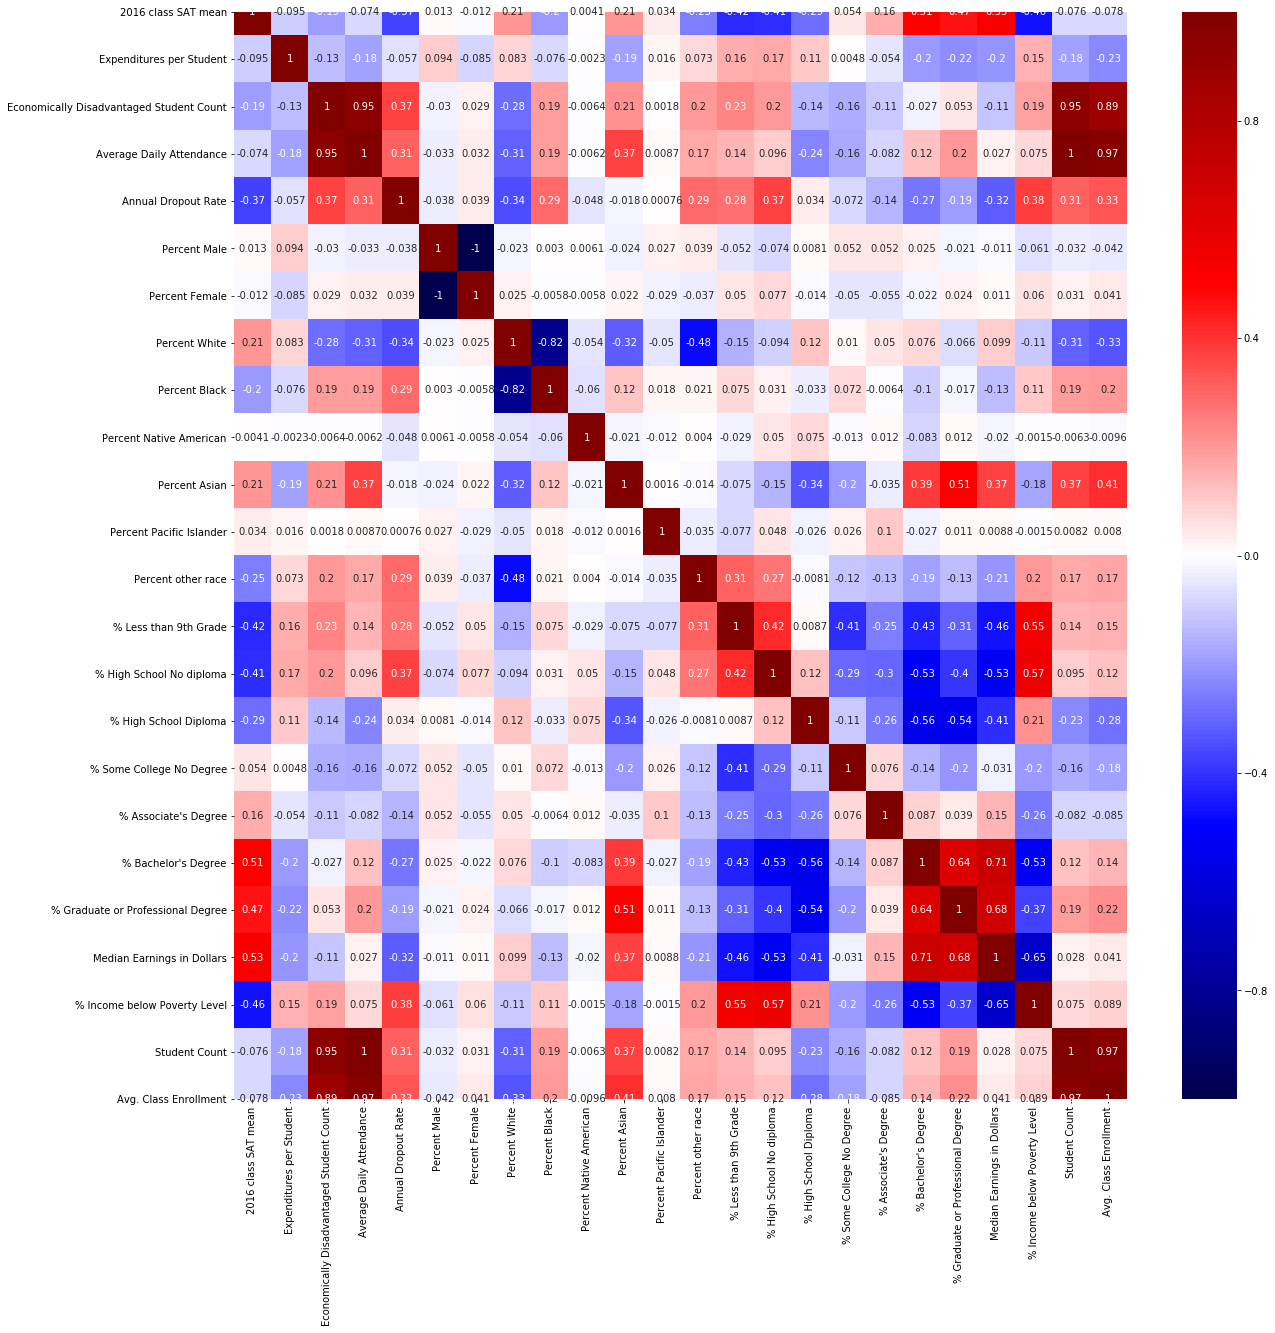

In [86]:
fig, ax = plt.subplots(figsize=(20,20))  
#ax.set_ylim(len(sat_df)-0.5, -0.5)
#sns.heatmap(sat_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);
ax.set_ylim(len(sat_analysis_df)-0.5, -0.5)
sns.heatmap(sat_analysis_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

//anaconda3/envs/metis/lib/python3.7/site-packages/seaborn/axisgrid.py:1306: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


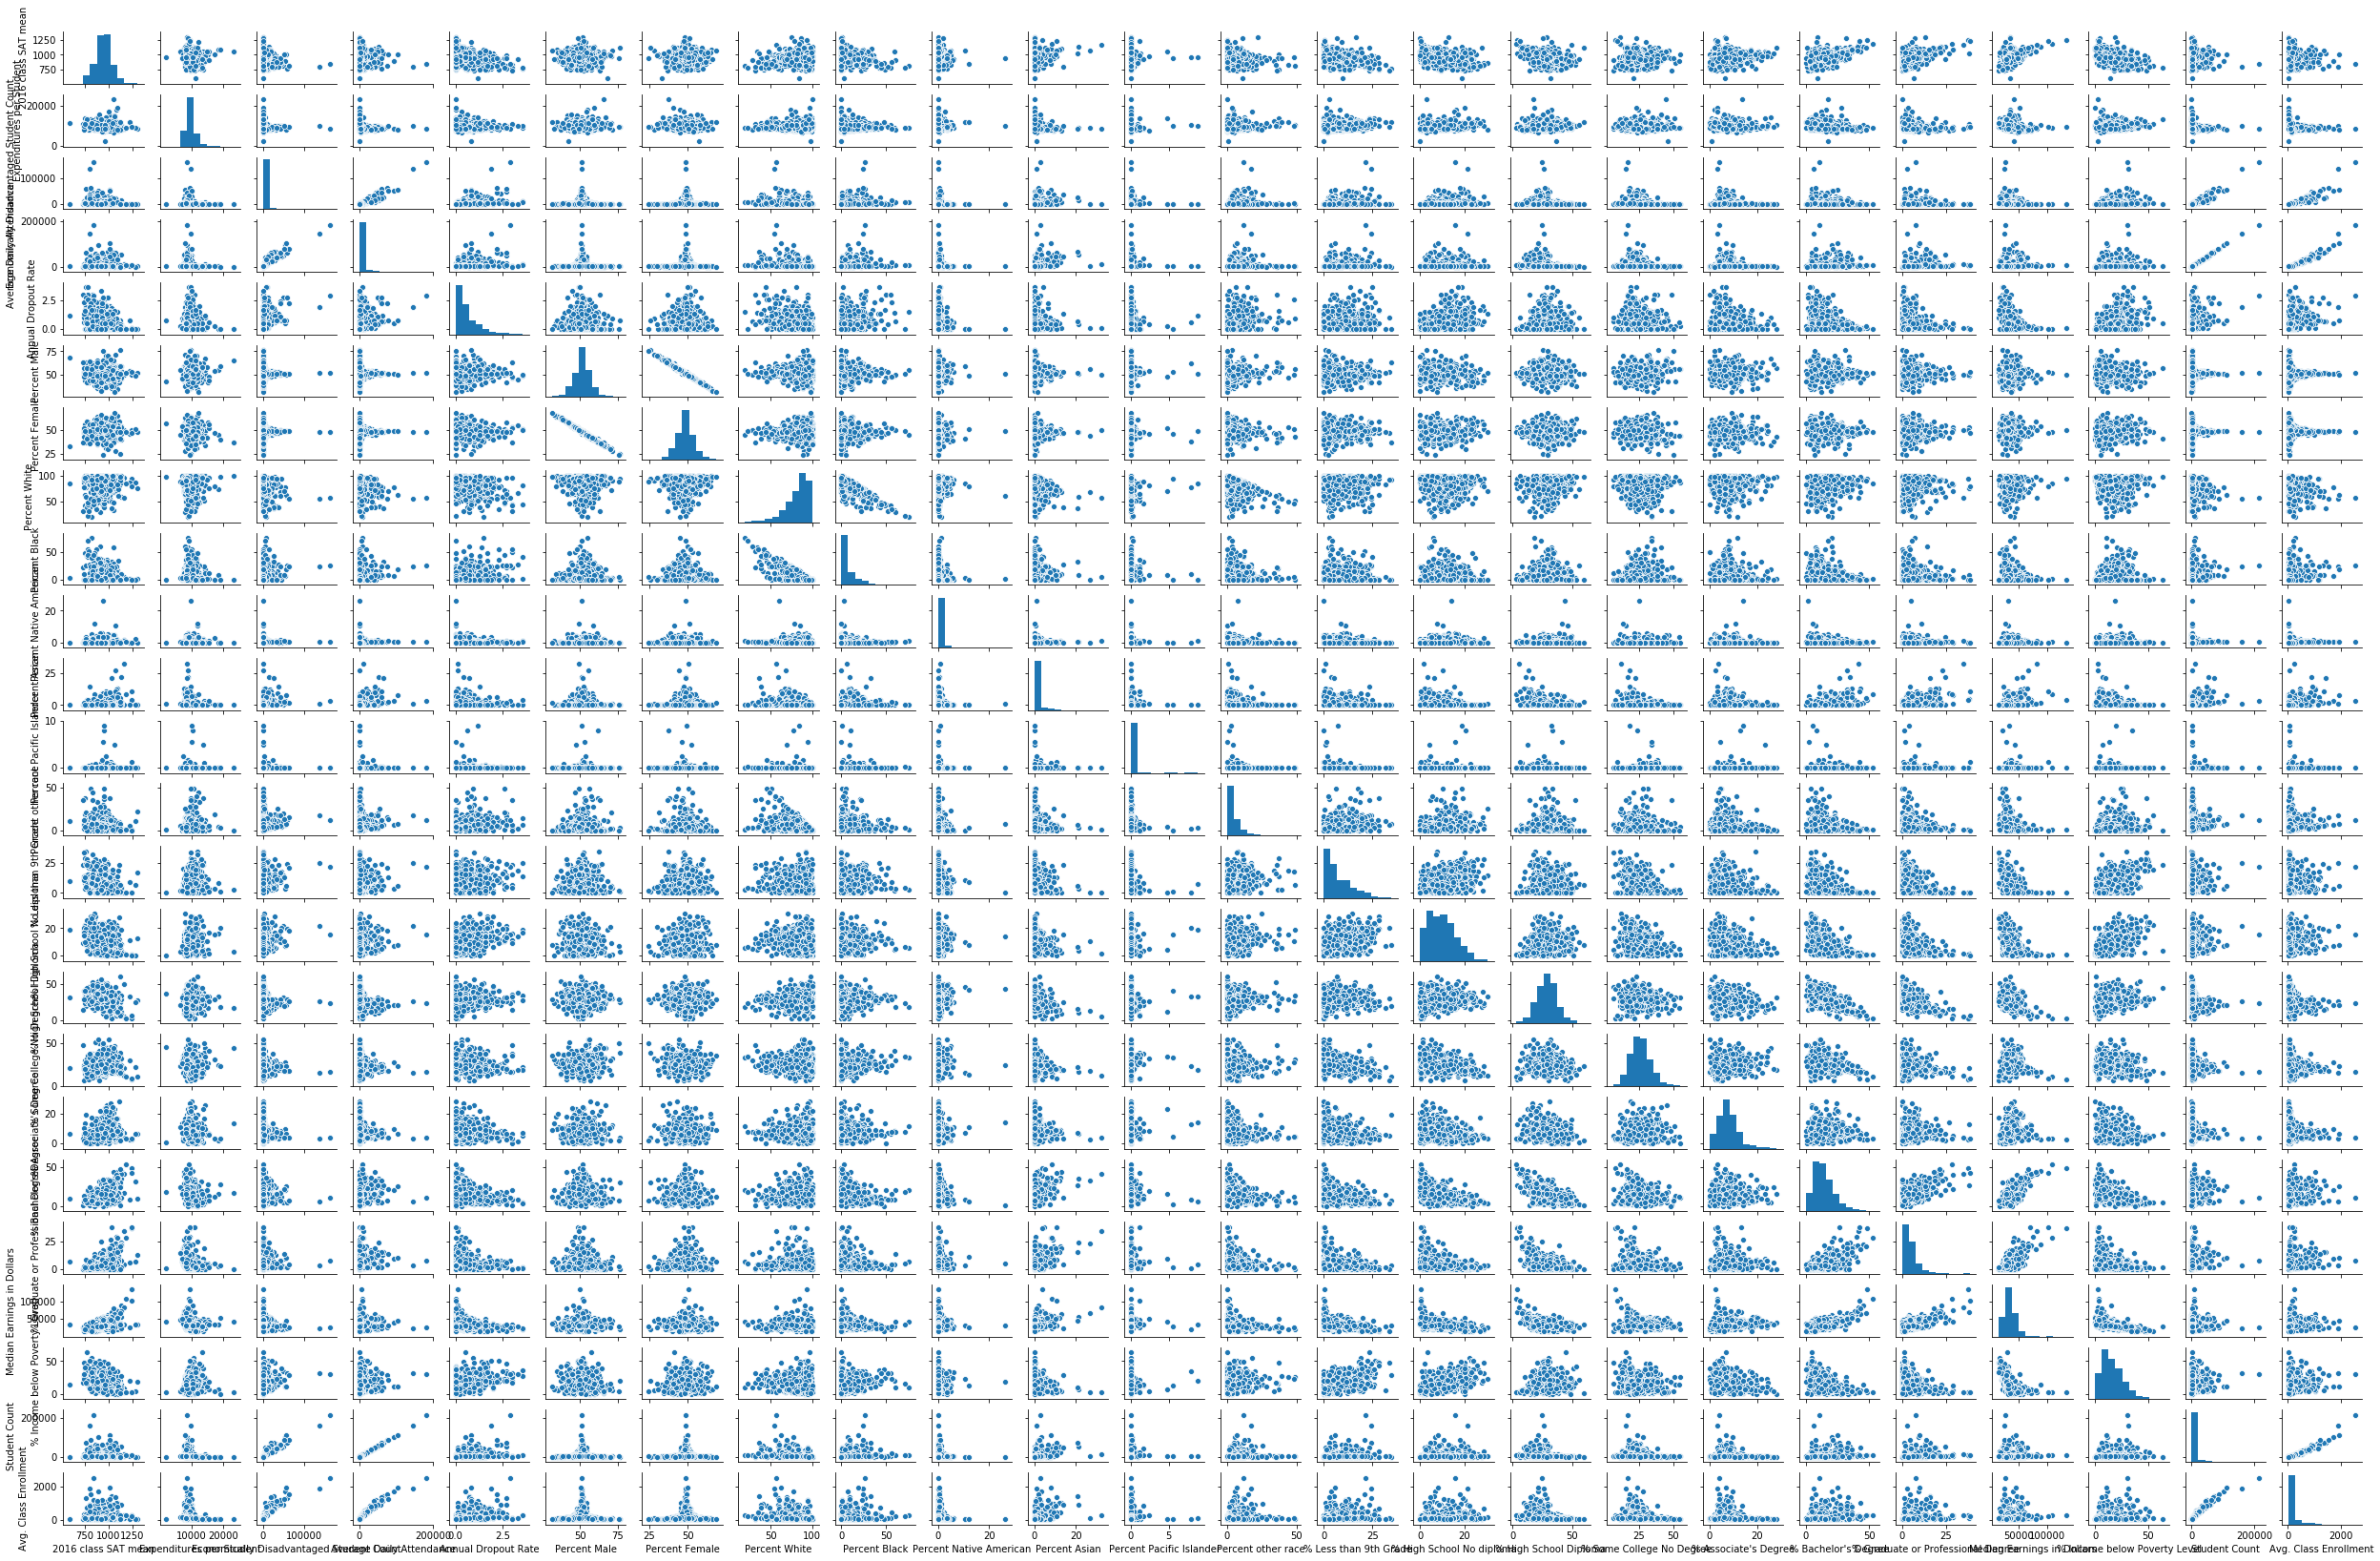

In [87]:
sns.pairplot(sat_analysis_df, height=1.2, aspect=1.5);

In [88]:
sat_analysis_df.columns

Index(['2016 class SAT mean', 'Expenditures per Student',
       'Economically Disadvantaged Student Count', 'Average Daily Attendance',
       'Annual Dropout Rate', 'Percent Male', 'Percent Female',
       'Percent White', 'Percent Black', 'Percent Native American',
       'Percent Asian', 'Percent Pacific Islander', 'Percent other race',
       '% Less than 9th Grade', '% High School No diploma',
       '% High School Diploma', '% Some College No Degree',
       '% Associate's Degree', '% Bachelor's Degree',
       '% Graduate or Professional Degree', 'Median Earnings in Dollars',
       '% Income below Poverty Level', 'Student Count',
       'Avg. Class Enrollment'],
      dtype='object')

In [89]:
y = sat_analysis_df['2016 class SAT mean']
X = sat_analysis_df.iloc[:, 1:]
#X = sat_analysis_df.iloc[:, 4:]

In [90]:
X.columns

Index(['Expenditures per Student', 'Economically Disadvantaged Student Count',
       'Average Daily Attendance', 'Annual Dropout Rate', 'Percent Male',
       'Percent Female', 'Percent White', 'Percent Black',
       'Percent Native American', 'Percent Asian', 'Percent Pacific Islander',
       'Percent other race', '% Less than 9th Grade',
       '% High School No diploma', '% High School Diploma',
       '% Some College No Degree', '% Associate's Degree',
       '% Bachelor's Degree', '% Graduate or Professional Degree',
       'Median Earnings in Dollars', '% Income below Poverty Level',
       'Student Count', 'Avg. Class Enrollment'],
      dtype='object')

Train test split

#overfit: Test dataset will have smaller R^2 than tranining dataset or MSE: test will have higher than
#MSE than train dataset; to fix: use regularization

#underfit: Both will have a high and similar MSE, both low R^2

#just right: low MSE or high R^2


#if you get a negative R^2 that means your model is worse than the average and so try again!

In [91]:
### test train split

def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    # takes x and y and gives back two versions or x and two versions of the y
    # test_size = 20 percent of data to test set and 80% to go to train set
    # 70 or 80% is common for train set, but really want to make sure that data trained and tested is evenly dist as
    # as possible across the data
    #X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
    #X_train, X_val, y_train, y_val = \
    X_to_split, X_test, y_to_split, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train, X_val, y_train, y_val = \
    X, X_test, y, y_test = train_test_split(X_to_split, y_to_split, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data or test data, NOT train data
    val_score = lr_model.score(X_val, y_val)
    train_score = lr_model.score(X_train, y_train)
    # report results
    print('Validation R^2 score was:', val_score)
    print('Training R^2 score was:', train_score)
    print('\nFeature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')
    return (lr_model,X_train, X_val, y_train, y_val,X_test, y_test, val_score, train_score)



In [92]:
(lr_model, X_train, X_val, y_train, y_val,X_test, y_test, val_score, train_score)= split_and_validate(X,y)

Validation R^2 score was: 0.1789644103153457
Training R^2 score was: 0.4716797824092027

Feature coefficient results: 

Expenditures per Student : 0.00
Economically Disadvantaged Student Count : -0.00
Average Daily Attendance : 0.01
Annual Dropout Rate : -13.57
Percent Male : -18.18
Percent Female : -17.25
Percent White : -2.00
Percent Black : -3.16
Percent Native American : -1.21
Percent Asian : -2.03
Percent Pacific Islander : 1.39
Percent other race : -2.51
% Less than 9th Grade : -19.86
% High School No diploma : -19.32
% High School Diploma : -18.81
% Some College No Degree : -18.11
% Associate's Degree : -18.28
% Bachelor's Degree : -17.70
% Graduate or Professional Degree : -15.46
Median Earnings in Dollars : 0.00
% Income below Poverty Level : -0.31
Student Count : -0.01
Avg. Class Enrollment : -0.07


In [93]:
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

//anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     2016 class SAT mean   R-squared:                       0.472
Model:                             OLS   Adj. R-squared:                  0.443
Method:                  Least Squares   F-statistic:                     16.19
Date:                 Thu, 10 Oct 2019   Prob (F-statistic):           1.66e-44
Time:                         11:40:44   Log-Likelihood:                -2443.0
No. Observations:                  441   AIC:                             4934.
Df Residuals:                      417   BIC:                             5032.
Df Model:                           23                                         
Covariance Type:             nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                     4721.3697    943.791      5.003      0.000    2866.189    6576.550
Expenditures per Student                     0.0026      0.002      1.149      0.251      -0.002       0.007
Economically Disadvantaged Student Count    -0.0025      0.001     -2.199      0.028      -0.005      -0.000
Average Daily Attendance                     0.0107      0.008      1.327      0.185      -0.005       0.026
Annual Dropout Rate                        -13.5711      5.980     -2.270      0.024     -25.325      -1.817
Percent Male                               -18.1791      8.416     -2.160      0.031     -34.723      -1.635
Percent Female                             -17.2458      8.457     -2.039      0.042     -33.869      -0.622
Percent White                               -2.0034      0.985     -2.034      0.043      -3.939      -0.067
Percent Black                               -3.1645      1.041     -3.039      0.003      -5.211      -1.118
Percent Native American                     -1.2080      2.685     -0.450      0.653      -6.485       4.069
Percent Asian                               -2.0269      1.644     -1.233      0.218      -5.259       1.205
Percent Pacific Islander                     1.3891      4.654      0.298      0.765      -7.758      10.537
Percent other race                          -2.5071      1.133     -2.213      0.027      -4.734      -0.281
% Less than 9th Grade                      -19.8565      4.913     -4.042      0.000     -29.514     -10.199
% High School No diploma                   -19.3223      4.919     -3.928      0.000     -28.991      -9.654
% High School Diploma                      -18.8080      4.902     -3.837      0.000     -28.443      -9.173
% Some College No Degree                   -18.1129      4.887     -3.706      0.000     -27.719      -8.507
% Associate's Degree                       -18.2840      4.958     -3.688      0.000     -28.030      -8.538
% Bachelor's Degree                        -17.7031      4.892     -3.619      0.000     -27.319      -8.087
% Graduate or Professional Degree          -15.4553      4.996     -3.094      0.002     -25.275      -5.636
Median Earnings in Dollars                   0.0010      0.000      2.111      0.035    7.13e-05       0.002
% Income below Poverty Level                -0.3083      0.488     -0.632      0.528      -1.267       0.650
Student Count                               -0.0073      0.008     -0.959      0.338      -0.022       0.008
Avg. Class Enrollment                       -0.0701      0.062     -1.129      0.260      -0.192       0.052
==============================================================================
Omnibus:                       39.588   Durbin-Wat

In [94]:
rmse = mean_squared_error(y_val,lr_model.predict(X_val) )
r2 = r2_score(y_val, lr_model.predict(X_val))
mae = mean_absolute_error(y_val, lr_model.predict(X_val))
print(f'RMSE: {rmse} and r2 validation data: {r2} and MAE:{mae}')

RMSE: 6176.00296204277 and r2 validation data: 0.1789644103153457 and MAE:54.75921436307528


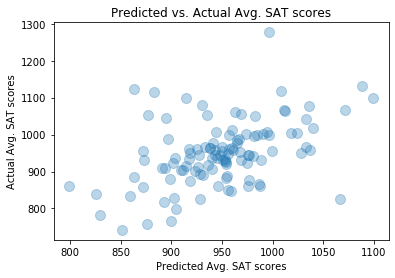

In [95]:
fig,ax = plt.subplots(1,1);
ax.scatter(lr_model.predict(X_val), y_val, s=100, alpha=.3);
ax.set_ylabel('Actual Avg. SAT scores');
ax.set_xlabel('Predicted Avg. SAT scores');
plt.title("Predicted vs. Actual Avg. SAT scores");
#plt.text(900,1250,f'R^2 train = {train_score}',horizontalalignment='right');
#plt.text(1400,1250,f'R^2 test = {val_score}',horizontalalignment='right');
#plt.savefig('actual_v_pred_scatterplt_mvp', format='png')

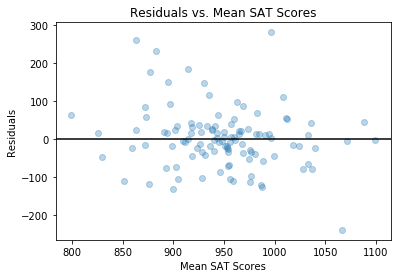

In [96]:
#residual plot of residuals  vs val_y data
y_pred = lr_model.predict(X_val)
residual = y_val - y_pred
plt.scatter(y_pred , residual, alpha=.3) #top heavy, normal residual
#plt.scatter(y_val, residual, alpha=.3) #suggests underfitting
plt.xlabel("Mean SAT Scores")
plt.ylabel("Residuals")
plt.title("Residuals vs. Mean SAT Scores")
plt.axhline(y=0, color='black')
#plt.savefig('actual_v_pred_scatterplt_mvp', format='png')

In [97]:
type(residual)
y_val

71      964.0
453     840.0
116    1064.0
447    1017.0
67      934.0
        ...  
564     937.0
607    1118.0
680     920.0
628     924.0
29      958.0
Name: 2016 class SAT mean, Length: 111, dtype: float64

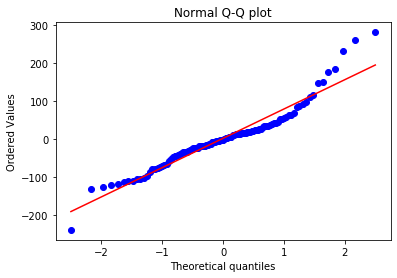

In [98]:
#QQ plot
stats.probplot(residual, dist="norm", plot=plt);
plt.title("Normal Q-Q plot");

In [99]:
#plt.scatter(X_val,y_pred)
#plt.plot(X_val, y_pred, color='blue',linewidth=1)
#y_pred

In [100]:
#single plots
# fig,ax = plt.subplots(1,1);
# ax.scatter(X.iloc[:, 18:19], y);
# ax.set_ylabel('y actual');
# ax.set_xlabel('y predicted');

In [101]:
#standardize the features before model and look at pair plot


In [102]:
#Standardizing with std scaler increased my test R^2 minimally and 
#decreased my train R^2 minimally

In [103]:
#from sklearn.metrics import mean_squared_error

In [104]:
#mean_squared_error(y, lr_model.fit(X))

In [105]:
# try to log transform the ones along the diagonal of the pair plots
# do 1- white % and then use that instead of white percentage and the log transform

In [106]:
X, y = sat_analysis_df.drop('2016 class SAT mean',axis=1), sat_analysis_df['2016 class SAT mean']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)


#run the CV

#instantiate kfs
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

#for each fold setup train and validate
for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    #fit training data and append score from validation to list
    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Simple regression scores:  [0.17083341512729175, 0.31551221473319746, 0.3972422234469542, 0.3342920998471305, 0.41515368388209306]
Ridge scores:  [0.18496894281626186, 0.31538999591749994, 0.4303253450289335, 0.33845310493658254, 0.41812815001234105] 

Simple mean cv r^2: 0.327 +- 0.086
Ridge mean cv r^2: 0.337 +- 0.088
Ridge Regression test R^2: 0.415


In [107]:
sat_df_non_white_added_white_removed = sat_analysis_df.copy(deep=True)
sat_df_non_white_added_white_removed['Percent White'] = 100 - sat_df_non_white_added_white_removed["Percent White"]
sat_df_non_white_added_white_removed.rename(columns={'Percent White': 'Percent Non White'}, inplace=True)
sat_df_non_white_added_white_removed

2016 class SAT mean  Expenditures per Student  \
0                  978.0                   14278.0   
1                  978.0                    8509.0   
2                  932.0                    8994.0   
3                  918.0                   10021.0   
4                  937.0                    9169.0   
..                   ...                       ...   
685                964.0                   10331.0   
686                965.0                    8404.0   
687               1038.0                   11229.0   
688                821.0                   11415.0   
689                923.0                   13329.0   

     Economically Disadvantaged Student Count  Average Daily Attendance  \
0                                         210                   560.125   
1                                         648                  1134.768   
2                                         446                   713.236   
3                                        2458                  3052.135   
4                                        1020                  1507.839   
..                                        ...                       ...   
685                                       850                  1521.770   
686                                      1353                  2397.210   
687                                      2928                  3187.021   
688                                      1450                  1795.871   
689                                       424                   443.784   

     Annual Dropout Rate  Percent Male  Percent Female  Percent Non White  \
0                    1.0          67.3            33.6               18.6   
1                    0.0          55.3            44.7                3.0   
2                    0.3          43.9            56.1               36.5   
3                    0.6          45.5            54.5               35.9   
4                    0.3          62.3            37.7               26.5   
..                   ...           ...             ...                ...   
685                  0.0          50.6            49.4               11.8   
686                  0.5          49.2            50.6                9.5   
687                  1.3          54.7            45.2                1.5   
688                  1.7          55.7            44.3                7.6   
689                  0.0          58.3            41.7                3.9   

     Percent Black  Percent Native American  ...  % High School No diploma  \
0             18.6                      0.0  ...                       1.0   
1              1.1                      0.0  ...                      18.7   
2             18.2                      0.0  ...                      11.2   
3             25.7                      0.0  ...                       9.9   
4             24.3                      1.3  ...                       3.9   
..             ...                      ...  ...                       ...   
685            3.4                      0.0  ...                       6.2   
686            2.8                      0.0  ...                       4.9   
687            0.4                      0.0  ...                      20.3   
688            0.0                      0.0  ...                      27.2   
689            0.0                      0.0  ...                      13.6   

     % High School Diploma  % Some College No Degree  % Associate's Degree  \
0                     23.2                      45.1                  25.6   
1                     30.9                      30.5                   3.1   
2                     20.8                      24.8                  11.2   
3                     35.8                      22.8                   5.6   
4                     34.4                      30.9                  10.4   
..                     ...                       ...                   ...   
685                   31.7                     

In [108]:
#standard scale and log pipeline everything except SAT scores\
#add one to all features to ensure that log can be applied without there being zeros in the column
sat_df_non_white_added_white_removed = sat_df_non_white_added_white_removed.iloc[:,:] + 1
sat_df_non_white_added_white_removed
X_2 = sat_df_non_white_added_white_removed.iloc[:, 1:]
y_2 = sat_df_non_white_added_white_removed.iloc[:, 0:1]

In [109]:
posTransform = make_pipeline(FunctionTransformer(np.log), StandardScaler())

mapper = DataFrameMapper([
    (list(X_2.columns), posTransform)
])

mapper.fit_transform(X_2)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([[ 2.58702644, -1.15383734, -0.95872072, ..., -0.84681903,
        -1.00064863, -1.18567703],
       [-0.77240398, -0.38951935, -0.44060757, ..., -0.38347821,
        -0.45429847, -0.39186189],
       [-0.41262498, -0.64316909, -0.78143896, ...,  0.35680461,
        -0.76169132, -0.6673897 ],
       ...,
       [ 1.02786844,  0.63561483,  0.31775919, ...,  1.53712527,
         0.35843188,  0.53383131],
       [ 1.13449766,  0.15779773, -0.10353326, ...,  1.30131806,
        -0.06647689,  0.06035172],
       [ 2.14061873, -0.6775012 , -1.12945199, ...,  1.0524212 ,
        -1.12917504, -0.94508549]])

In [110]:
X_to_split, X_test, y_to_split, y_test = \
        train_test_split(X_2, y_2, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = \
        train_test_split(X_to_split, y_to_split, test_size=0.2, random_state=42)

# fit linear regression to training data
#lr_model = LinearRegression()
#lr_model.fit(X_train, y_train)

pipe = make_pipeline(mapper, LinearRegression())

val R^2: 0.3363488475616352, train R^2: 0.43209574048943883


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_fu

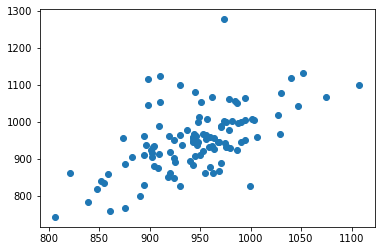

In [111]:
pipe.fit(X_train, y_train)

yhat = pipe.predict(X_val)
plt.scatter(yhat,y_val)

print(f'val R^2: {pipe.score(X_val,y= y_val)}, train R^2: {pipe.score(X_train,y= y_train)}')

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


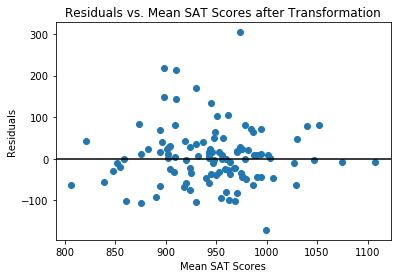

In [112]:
#residual plot of residuals  vs val_y data
y_pred = pipe.predict(X_val)
residual = y_val - y_pred

plt.scatter(y_pred , residual)
plt.xlabel("Mean SAT Scores")
plt.ylabel("Residuals")
plt.title("Residuals vs. Mean SAT Scores after Transformation")
plt.axhline(y=0, color='black')
#plt.savefig('actual_v_pred_scatterplt_mvp', format='png')

In [113]:
r2=pipe.score(X_val, y_val)
rmse = mean_squared_error(y_val,y_pred)
#r2 = pipe.score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f'RMSE: {rmse} and r2 validation data: {r2} and MAE:{mae}')

RMSE: 4992.124013523804 and r2 validation data: 0.3363488475616352 and MAE:49.63193594450525


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Normal Q-Q plot')

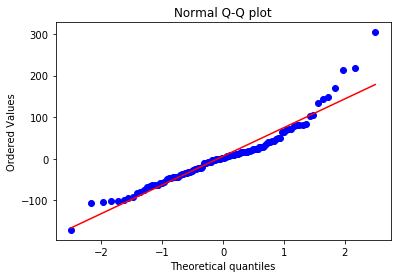

In [114]:
#QQ plot
stats.probplot(residual["2016 class SAT mean"], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [115]:
#interactions
residual
#cols = [col for col in list(sat_df_non_white_added_white_removed.columns) if sum(sat_df_non_white_added_white_removed.loc[:,col] == 0) > 0]

2016 class SAT mean
71              8.778428
453           -10.500727
116            70.374300
447            -9.212913
67            -26.813303
..                   ...
564             6.204384
607            79.165114
680           -31.888818
628            23.687165
29             -0.650563

[111 rows x 1 columns]

In [116]:
# #crossvalidate and regularize and get the best features
# sat_df_non_white_added_white_removed = sat_df_non_white_added_white_removed.iloc[:,:] + 1
# sat_df_non_white_added_white_removed
# X_2 = sat_df_non_white_added_white_removed.iloc[:, 1:]
# y_2 = sat_df_non_white_added_white_removed.iloc[:, 0:1]

In [117]:
# sum(sat_df_non_white_added_white_removed.loc[:,"Percent Native American"] == 0) > 389

In [118]:
# #random forest
# features = X.columns
# response = ['2016 class SAT mean']

# rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)

# rnd_clf.fit(X_train, y_train)

In [119]:
# for name, importance in zip(X_train, rnd_clf.feature_importances_):
#     print(name, "=", importance)

# feat = X_train
# importances = rnd_clf.feature_importances_
# indices = np.argsort(importances)

# plt.figure(1)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)),feat.columns[indices])
# plt.xlabel('Relative Importance')
# plt.show()

In [120]:
# #residual plots
# y_pred = lr_model.predict(X_val)
# residual = y_val - y_pred

# plt.scatter(y_val , residual)
# plt.xlabel("y_train")
# plt.ylabel("Residuals")
# plt.title("Residuals vs. Mean SAT scores")
# plt.axhline(y=0, color='black')
# #plt.plot(y_train, residual)

In [121]:
#do the same with scaled data

#future work

# cols = X.columns
# sat_analysis_plot_df = sat_analysis_df[cols].copy(deep=True)
# sat_analysis_plot_df['2016 class SAT mean'] = y
# sat_analysis_plot_df['predict'] = fit.predict(X_val)
# sat_analysis_plot_df['resid']= sat_analysis_plot_df['2016 class SAT mean']-data['predict']

# data['predict']=fit.predict(X)
# data['resid']=data.cnt-data.predict
# with sns.axes_style('white'):
#     plot=data.plot(kind='scatter',
#                   x='predict',y='resid',alpha=0.2,figsize=(10,6))
# sat_analysis_plot_df['predictions']
# sns.residplot(results.)

In [122]:
# QQ plots??; residuals should be some noise that can't be captured, but mine shows that there is a
# pattern, so will explore the 

Flow: Talk about scraping and difficulties with data feature engineering and combining data sets from different sources. Next I looked at the one to one plot of the predicted vs. the actual y values. This plot is very noisy. The pairplots showed that my features were skewed, so I used a log transformation to try and normalize that data. The R^2 before the transform of the test and train is... The R^2 after the test and train is, so it was a very small increase... The residual plots for both before and after the transform suggests that there is some trend to be explored that has not been flushed out in the features. Next try to remove any multicollinearity(trends) with ridge and lasso regularization

#future work - non parametric model because this data appears to be non linearly correlated or trying to look at percentiles instead of raw sat scores as these may be more normally distributed???

In [123]:
#show him the work thus far, ask if done correctly. Ask about QQ plots... 
#ask how to transform or which to transform because residuals look worse after 
#transformation done
#

In [124]:
#Greatest betas neg or pos are the greatest predictor and pvalue

In [125]:
#make Economically Dis student count into a rate
#remove student count and average daily attendance and female as they all had correlations with other variables
#show plot of these correlations??? and speak to how their B coeff were lower, so I dropped them

In [126]:
sat_analysis2_df = sat_analysis_df.copy(deep=True)
sat_analysis2_df['Economically Disadvantaged Student Count'] = sat_analysis2_df['Economically Disadvantaged Student Count']/ sat_analysis_df['Student Count']
sat_analysis2_df.rename(columns={'Economically Disadvantaged Student Count': '% of Economically Disadvantaged Students'},inplace=True)


In [127]:
sat_analysis2_df.drop(columns= ['Average Daily Attendance','Student Count','Percent Female'],inplace=True)

In [128]:
sat_analysis2_df

2016 class SAT mean  Expenditures per Student  \
0                  978.0                   14278.0   
1                  978.0                    8509.0   
2                  932.0                    8994.0   
3                  918.0                   10021.0   
4                  937.0                    9169.0   
..                   ...                       ...   
685                964.0                   10331.0   
686                965.0                    8404.0   
687               1038.0                   11229.0   
688                821.0                   11415.0   
689                923.0                   13329.0   

     % of Economically Disadvantaged Students  Annual Dropout Rate  \
0                                    0.364583                  1.0   
1                                    0.532457                  0.0   
2                                    0.558198                  0.3   
3                                    0.733731                  0.6   
4                                    0.640704                  0.3   
..                                        ...                  ...   
685                                  0.484607                  0.0   
686                                  0.541417                  0.5   
687                                  0.791351                  1.3   
688                                  0.700822                  1.7   
689                                  0.877847                  0.0   

     Percent Male  Percent White  Percent Black  Percent Native American  \
0            67.3           81.4           18.6                      0.0   
1            55.3           97.0            1.1                      0.0   
2            43.9           63.5           18.2                      0.0   
3            45.5           64.1           25.7                      0.0   
4            62.3           73.5           24.3                      1.3   
..            ...            ...            ...                      ...   
685          50.6           88.2            3.4                      0.0   
686          49.2           90.5            2.8                      0.0   
687          54.7           98.5            0.4                      0.0   
688          55.7           92.4            0.0                      0.0   
689          58.3           96.1            0.0                      0.0   

     Percent Asian  Percent Pacific Islander  ...  % Less than 9th Grade  \
0              0.0                       0.0  ...                    0.0   
1              0.0                       0.0  ...                    0.3   
2              1.4                       0.0  ...                    8.8   
3              1.0                       0.0  ...                   11.6   
4              0.0                       0.0  ...                    6.8   
..             ...                       ...  ...                    ...   
685            1.5                       0.0  ...                   21.0   
686            0.0                       0.0  ...                   15.5   
687            0.0                       0.0  ...                   19.6   
688            0.0                       0.0  ...                    8.0   
689            0.0                       0.0  ...                    3.0   

     % High School No diploma  % High School Diploma  \
0                         1.0                   23.2   
1                        18.7                   30.9   
2                        11.2                   20.8   
3                         9.9                   35.8   
4                         3.9                   34.4   
..                        ...                    ...   
685                       6.2                   31.7   
686                       4.9                   30.7   
687                      20.3                   26.3   
688                      27.2                   26.4   
689                      13.6                   28.8   

     % Some Coll

In [129]:
X_2 = sat_analysis2_df.iloc[:, 1:]
y_2 = sat_analysis2_df['2016 class SAT mean']

In [130]:
(lr_model, X_train, X_val, y_train, y_val,X_test, y_test, val_score, train_score)= split_and_validate(X_2,y_2)

Validation R^2 score was: 0.27715096084073554
Training R^2 score was: 0.48072490484983305

Feature coefficient results: 

Expenditures per Student : 0.00
% of Economically Disadvantaged Students : -137.83
Annual Dropout Rate : -12.35
Percent Male : -0.99
Percent White : -2.27
Percent Black : -3.07
Percent Native American : -1.65
Percent Asian : -1.55
Percent Pacific Islander : 2.01
Percent other race : -2.72
% Less than 9th Grade : -19.22
% High School No diploma : -18.58
% High School Diploma : -18.31
% Some College No Degree : -17.94
% Associate's Degree : -17.89
% Bachelor's Degree : -17.69
% Graduate or Professional Degree : -15.32
Median Earnings in Dollars : 0.00
% Income below Poverty Level : 0.18
Avg. Class Enrollment : -0.02


In [131]:
X, y = sat_analysis2_df.drop('2016 class SAT mean',axis=1), sat_analysis2_df['2016 class SAT mean']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)


#run the CV

#instantiate kfs
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

#for each fold setup train and validate
for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    #fit training data and append score from validation to list
    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Simple regression scores:  [0.23704509793530315, 0.41849731711468874, 0.47858330406588345, 0.34126666211502343, 0.3308118658850042]
Ridge scores:  [0.24763406947526945, 0.41730071141388086, 0.4943801407331756, 0.3417429090724565, 0.33185901715930544] 

Simple mean cv r^2: 0.361 +- 0.082
Ridge mean cv r^2: 0.367 +- 0.084
Ridge Regression test R^2: 0.443


In [132]:
#random state makes this repeatable
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

#setting cv=kf makes it so you either get the same folds or if you take random_state out, 
#then you can get different folds
cross_val_score(lm, X, y, cv=kf, scoring='r2')
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.40464815683057936
0.4033037488108272


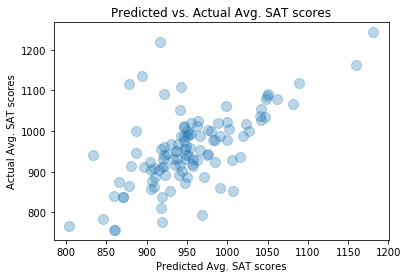

In [133]:
fig,ax = plt.subplots(1,1);
ax.scatter(lr_model.predict(X_val), y_val, s=100, alpha=.3);
ax.set_ylabel('Actual Avg. SAT scores');
ax.set_xlabel('Predicted Avg. SAT scores');
plt.title("Predicted vs. Actual Avg. SAT scores");
#plt.text(900,1250,f'R^2 train = {train_score}',horizontalalignment='right');
#plt.text(1400,1250,f'R^2 test = {val_score}',horizontalalignment='right');
#plt.savefig('actual_v_pred_scatterplt_mvp', format='png')

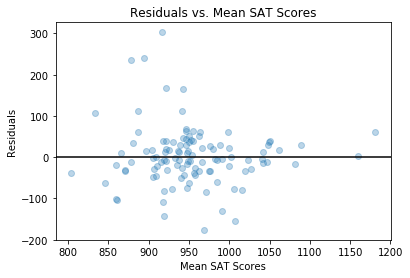

In [134]:
#residual plot of residuals  vs val_y data
y_pred = lr_model.predict(X_val)
residual = y_val - y_pred
plt.scatter(y_pred , residual, alpha=.3) #top heavy, normal residual plot
#plt.scatter(y_val, residual, alpha=.3) #suggests underfitting
plt.xlabel("Mean SAT Scores")
plt.ylabel("Residuals")
plt.title("Residuals vs. Mean SAT Scores")
plt.axhline(y=0, color='black')
#plt.savefig('actual_v_pred_scatterplt_mvp', format='png')

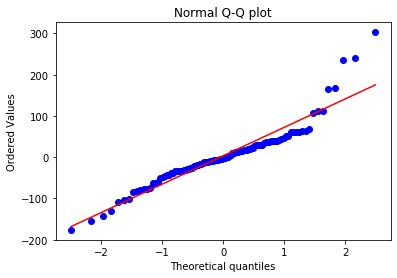

In [135]:
#QQ plot
stats.probplot(residual, dist="norm", plot=plt);
plt.title("Normal Q-Q plot");

//anaconda3/envs/metis/lib/python3.7/site-packages/seaborn/axisgrid.py:1306: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


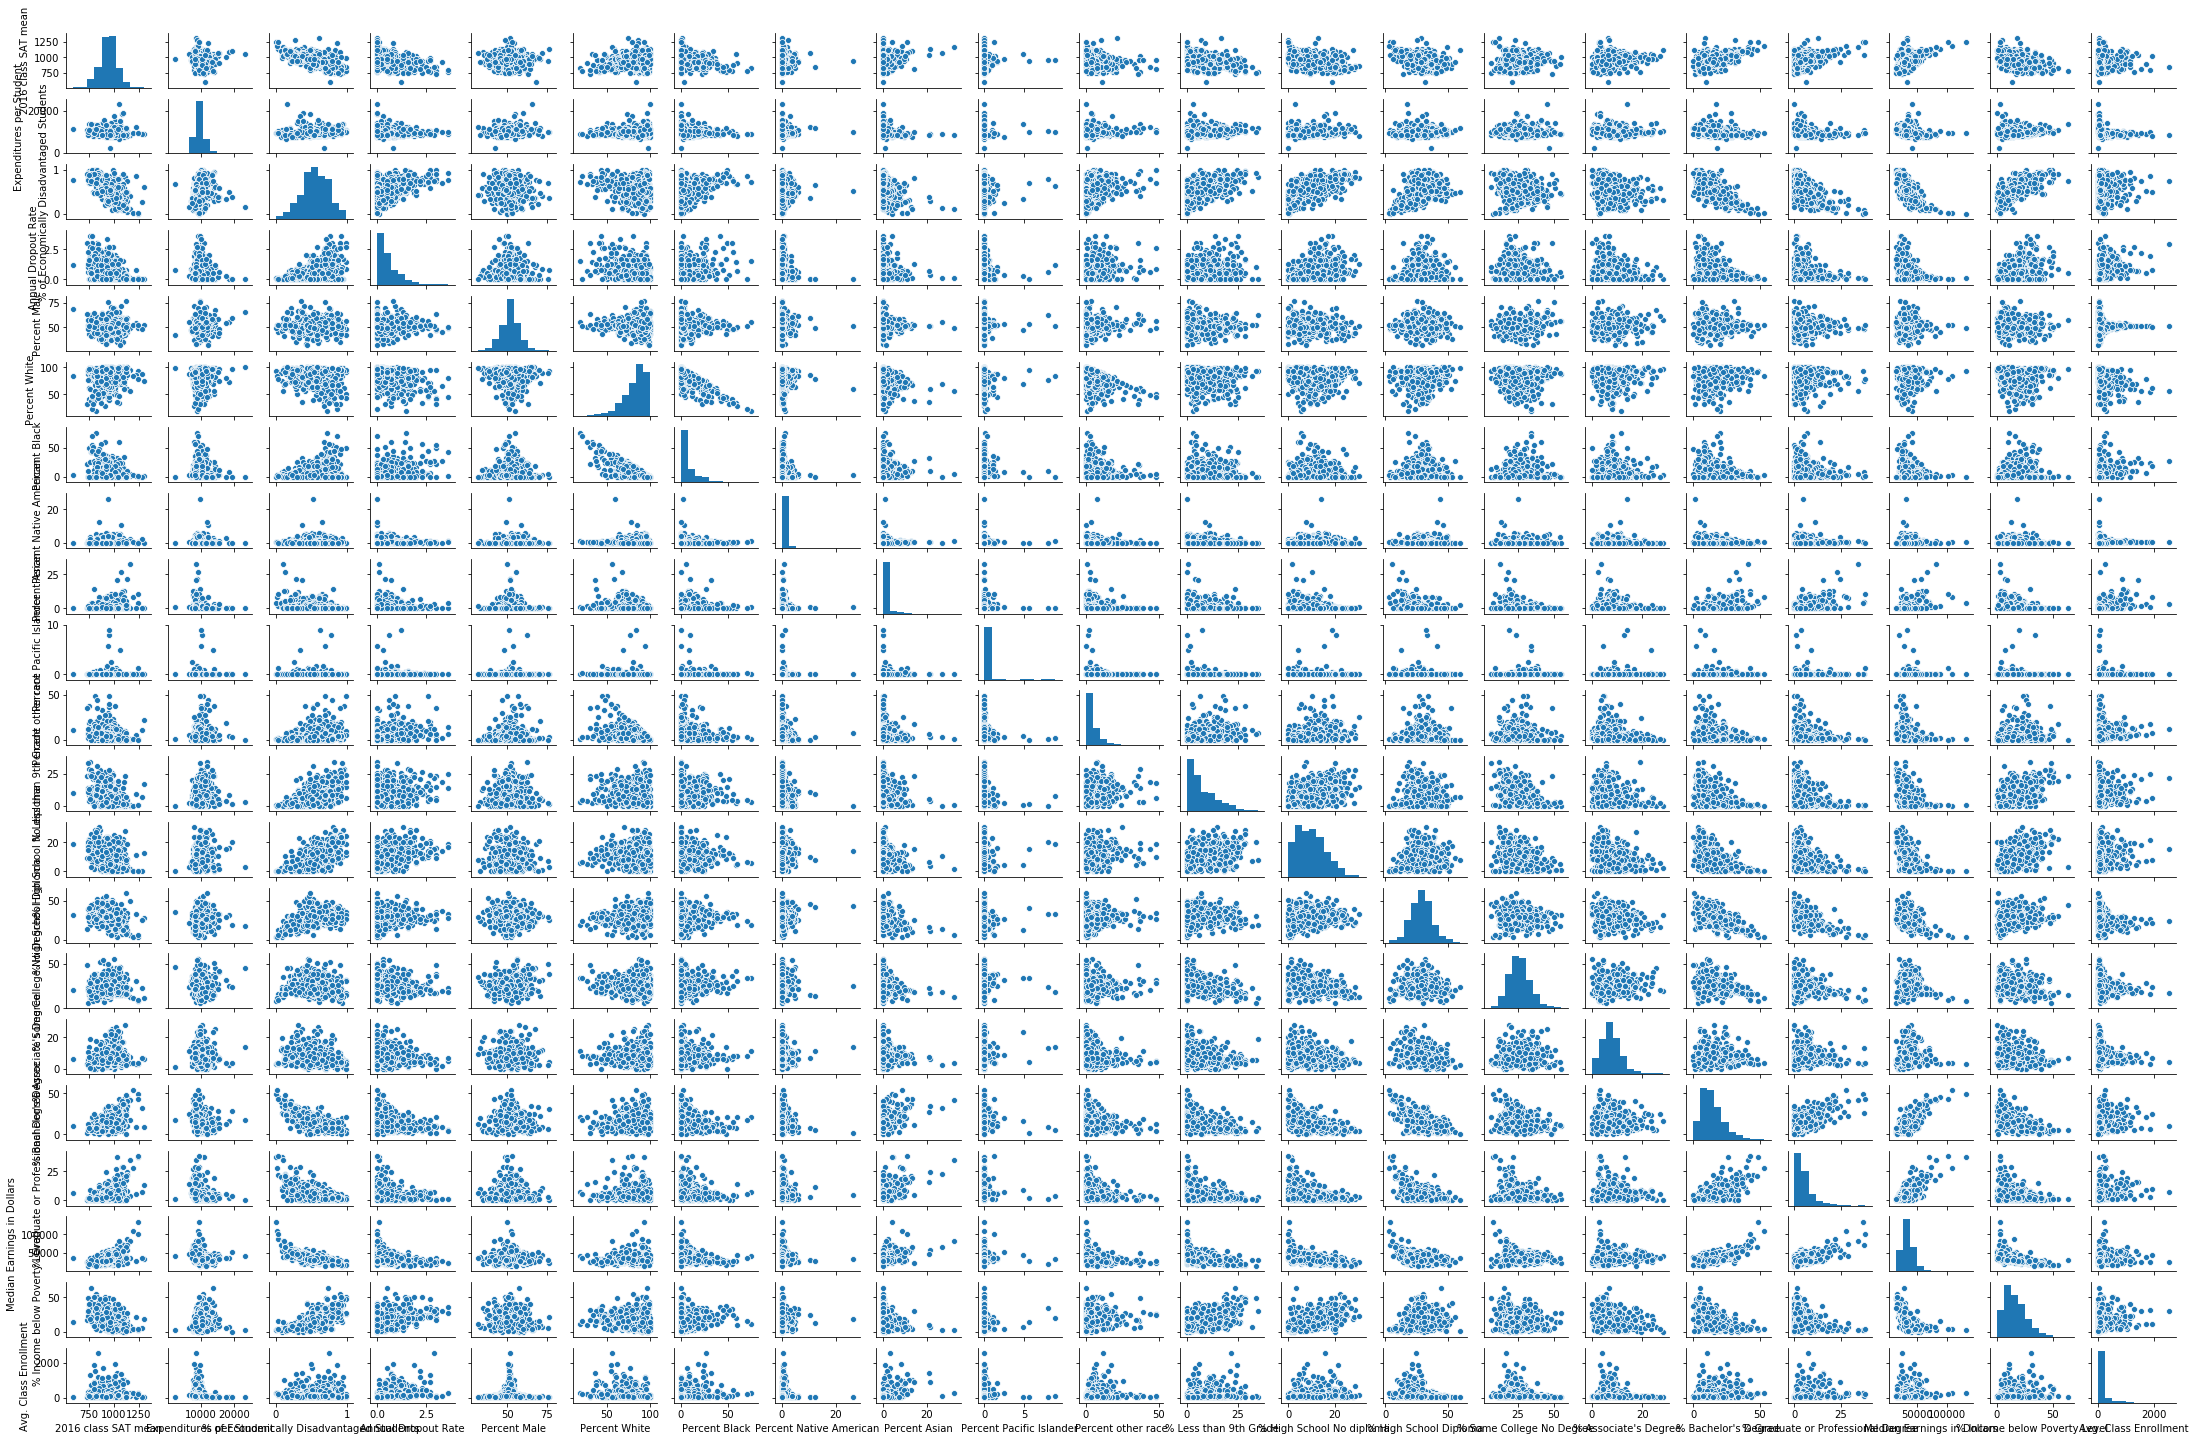

In [136]:
sns.pairplot(sat_analysis2_df, height=1.2, aspect=1.5);

In [137]:
X_2.columns


Index(['Expenditures per Student', '% of Economically Disadvantaged Students',
       'Annual Dropout Rate', 'Percent Male', 'Percent White', 'Percent Black',
       'Percent Native American', 'Percent Asian', 'Percent Pacific Islander',
       'Percent other race', '% Less than 9th Grade',
       '% High School No diploma', '% High School Diploma',
       '% Some College No Degree', '% Associate's Degree',
       '% Bachelor's Degree', '% Graduate or Professional Degree',
       'Median Earnings in Dollars', '% Income below Poverty Level',
       'Avg. Class Enrollment'],
      dtype='object')

#Things outside of the typical school performance that could predict SAT scores that could help
#schools and programs offer support to those that need extra support early on instead of trying to remedy
#the situation when it is too late (Get Ready offers SAT tutoring to underserved in 11 and 12 grade
#could intervention happen sooner and if so, where?)
#predicting on sociological factors is difficult because people are complex...?

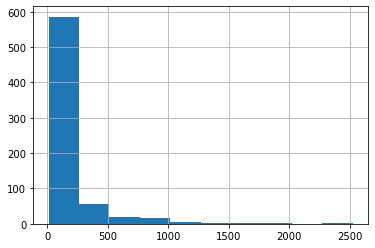

In [138]:
(sat_analysis2_df['Avg. Class Enrollment']).hist();

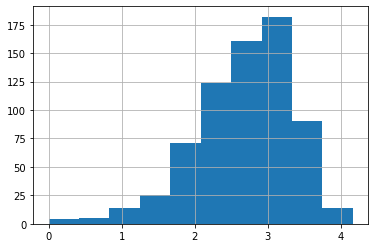

In [139]:
np.log(sat_analysis2_df['% Income below Poverty Level'] + 1).hist();

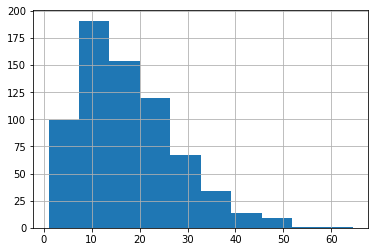

In [140]:
(sat_analysis2_df['% Income below Poverty Level'] + 1).hist();

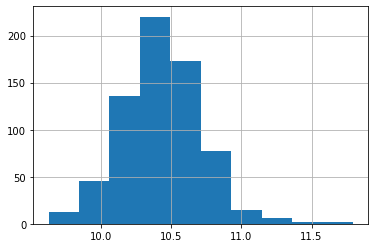

In [141]:
np.log(sat_analysis2_df['Median Earnings in Dollars'] ).hist();

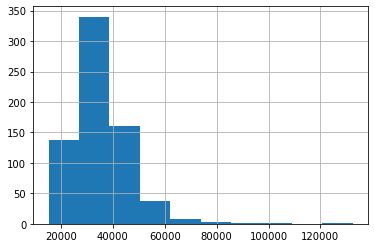

In [142]:
(sat_analysis2_df['Median Earnings in Dollars']).hist();

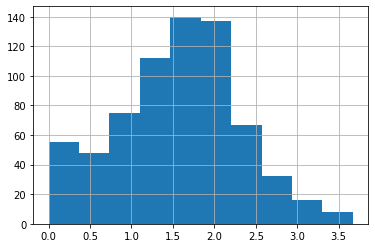

In [143]:
np.log(sat_analysis2_df['% Graduate or Professional Degree'] + 1).hist()

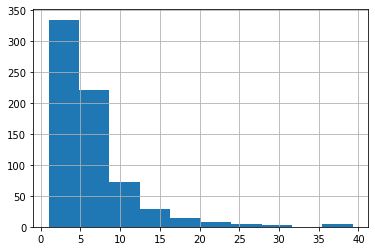

In [144]:
(sat_analysis2_df['% Graduate or Professional Degree'] + 1).hist()

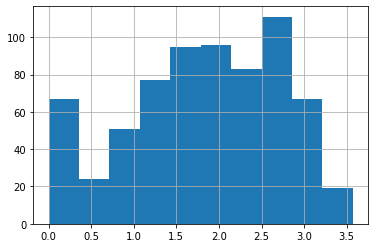

In [145]:
np.log(sat_analysis2_df['% Less than 9th Grade']+ 1).hist()

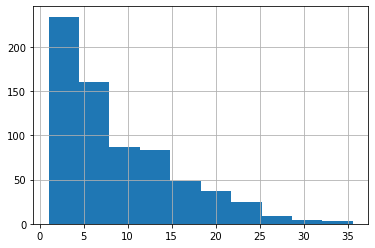

In [146]:
(sat_analysis2_df['% Less than 9th Grade']+ 1).hist()

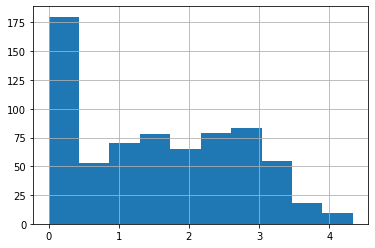

In [147]:
np.log(sat_analysis2_df['Percent Black']+ 1).hist()

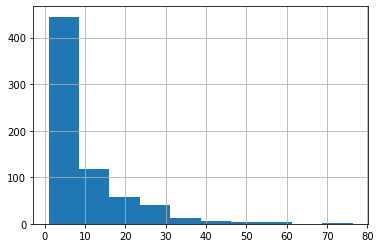

In [148]:
(sat_analysis2_df['Percent Black']+ 1).hist()

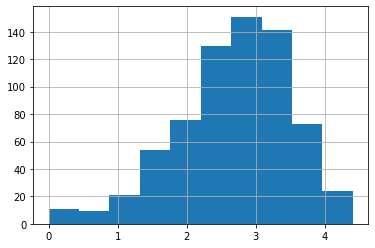

In [149]:
np.log(100 - sat_analysis2_df['Percent White'] + 1).hist()

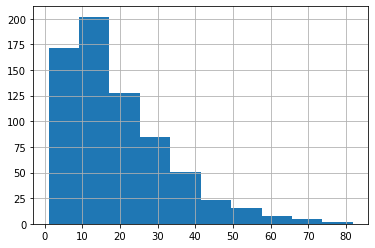

In [150]:
(100- sat_analysis2_df['Percent White'] + 1).hist()

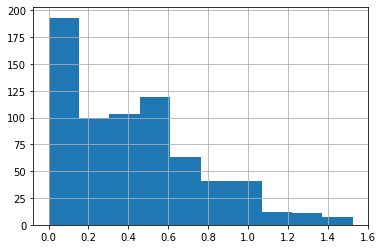

In [151]:
np.log(sat_analysis2_df['Annual Dropout Rate']+1).hist()

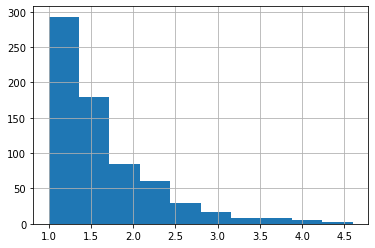

In [152]:
(sat_analysis2_df['Annual Dropout Rate']+1).hist()

In [153]:
#transform the data that looks not normally skewed


In [154]:
sat_analysis_trans_df = sat_analysis2_df.copy(deep=True)

In [155]:
sat_analysis_trans_df.rename(columns={'Percent White': 'Percent Non White'}, inplace=True)
transform_list = ['Avg. Class Enrollment','% Income below Poverty Level','Median Earnings in Dollars', 
         '% Graduate or Professional Degree','% Less than 9th Grade', 'Percent Non White',
         'Percent Black', 'Percent Native American','Percent Asian',
         'Percent Pacific Islander', 'Percent other race', 'Annual Dropout Rate']

sat_analysis_trans_df['Percent Non White'] = 100 - sat_analysis_trans_df['Percent Non White']

for col in transform_list:
    sat_analysis_trans_df[col] = 1 + sat_analysis_trans_df[col]


In [156]:
sat_analysis_trans_df

2016 class SAT mean  Expenditures per Student  \
0                  978.0                   14278.0   
1                  978.0                    8509.0   
2                  932.0                    8994.0   
3                  918.0                   10021.0   
4                  937.0                    9169.0   
..                   ...                       ...   
685                964.0                   10331.0   
686                965.0                    8404.0   
687               1038.0                   11229.0   
688                821.0                   11415.0   
689                923.0                   13329.0   

     % of Economically Disadvantaged Students  Annual Dropout Rate  \
0                                    0.364583                  2.0   
1                                    0.532457                  1.0   
2                                    0.558198                  1.3   
3                                    0.733731                  1.6   
4                                    0.640704                  1.3   
..                                        ...                  ...   
685                                  0.484607                  1.0   
686                                  0.541417                  1.5   
687                                  0.791351                  2.3   
688                                  0.700822                  2.7   
689                                  0.877847                  1.0   

     Percent Male  Percent Non White  Percent Black  Percent Native American  \
0            67.3               19.6           19.6                      1.0   
1            55.3                4.0            2.1                      1.0   
2            43.9               37.5           19.2                      1.0   
3            45.5               36.9           26.7                      1.0   
4            62.3               27.5           25.3                      2.3   
..            ...                ...            ...                      ...   
685          50.6               12.8            4.4                      1.0   
686          49.2               10.5            3.8                      1.0   
687          54.7                2.5            1.4                      1.0   
688          55.7                8.6            1.0                      1.0   
689          58.3                4.9            1.0                      1.0   

     Percent Asian  Percent Pacific Islander  ...  % Less than 9th Grade  \
0              1.0                       1.0  ...                    1.0   
1              1.0                       1.0  ...                    1.3   
2              2.4                       1.0  ...                    9.8   
3              2.0                       1.0  ...                   12.6   
4              1.0                       1.0  ...                    7.8   
..             ...                       ...  ...                    ...   
685            2.5                       1.0  ...                   22.0   
686            1.0                       1.0  ...                   16.5   
687            1.0                       1.0  ...                   20.6   
688            1.0                       1.0  ...                    9.0   
689            1.0                       1.0  ...                    4.0   

     % High School No diploma  % High School Diploma  \
0                         1.0                   23.2   
1                        18.7                   30.9   
2                        11.2                   20.8   
3                         9.9                   35.8   
4                         3.9                   34.4   
..                        ...                    ...   
685                       6.2                   31.7   
686                       4.9                   30.7   
687                      20.3                   26.3   
688                      27.2                   26.4   
689                      

In [157]:
non_trans_list = [col for col in sat_analysis_trans_df.columns if not col in transform_list]
non_trans_list = non_trans_list[1:]
non_trans_list


['Expenditures per Student',
 '% of Economically Disadvantaged Students',
 'Percent Male',
 '% High School No diploma',
 '% High School Diploma',
 '% Some College No Degree',
 "% Associate's Degree",
 "% Bachelor's Degree"]

In [158]:
pos_transform = make_pipeline(FunctionTransformer(np.log), StandardScaler())

mapper = DataFrameMapper([
    (['% Income below Poverty Level','Median Earnings in Dollars',
         '% Graduate or Professional Degree','% Less than 9th Grade',
         'Percent Black', 'Percent Native American','Percent Asian',
         'Percent Pacific Islander', 'Percent other race', 'Annual Dropout Rate'], pos_transform),
    (non_trans_list, StandardScaler())
])

mapper.fit_transform(sat_analysis_trans_df)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


array([[-0.84681903,  0.38089448, -2.04050196, ...,  2.54965834,
         4.09093705, -1.13230383],
       [-0.38347821,  0.96771042,  0.30447807, ...,  0.59420596,
        -1.13087024, -0.39651445],
       [ 0.35680461, -0.34906915, -0.78996845, ..., -0.16922408,
         0.74898038,  0.94452102],
       ...,
       [ 1.53712527, -2.46131541, -0.74057549, ..., -1.10676974,
        -0.41142124, -0.76440914],
       [ 1.30131806, -2.82020548, -1.00860187, ..., -1.83001925,
         2.23429446, -0.8593497 ],
       [ 1.0524212 , -0.61326425, -0.22617775, ..., -0.03528899,
         0.60973219,  0.09005594]])

In [159]:
X_3 = sat_analysis_trans_df.iloc[:, 1:]
y_3 = sat_analysis_trans_df['2016 class SAT mean']

X_to_split, X_test, y_to_split, y_test = \
        train_test_split(X_3, y_3, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = \
        train_test_split(X_to_split, y_to_split, test_size=0.2, random_state=42)

# fit linear regression to training data
#lr_model = LinearRegression()
#lr_model.fit(X_train, y_train)

pipe = make_pipeline(mapper, LinearRegression())

val R^2: 0.40795829125809424, test R^2: 0.4413234391905504


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_fu

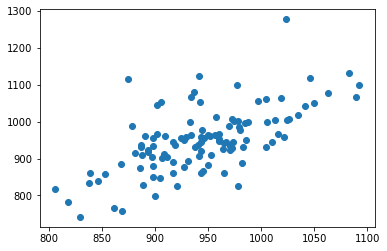

In [160]:
pipe.fit(X_train, y_train)

yhat = pipe.predict(X_val)
plt.scatter(yhat,y_val)
pipe.score()

print(f'val R^2: {pipe.score(X_val,y= y_val)}, test R^2: {pipe.score(X_train,y= y_train)}')

In [161]:
X_train

Expenditures per Student  % of Economically Disadvantaged Students  \
509                    8216.0                                  0.348829   
189                    8913.0                                  0.374643   
17                    11827.0                                  0.693957   
61                    10641.0                                  0.551181   
416                   13136.0                                  0.483085   
..                        ...                                       ...   
352                    8712.0                                  0.417417   
332                   17377.0                                  0.337296   
571                    8138.0                                  0.431565   
217                    8361.0                                  0.377436   
675                   10633.0                                  0.562771   

     Annual Dropout Rate  Percent Male  Percent Non White  Percent Black  \
509                  1.9          50.3               12.2            3.7   
189                  1.8          50.0                6.0            1.0   
17                   1.4          52.5               12.9            1.0   
61                   1.0          61.8                3.9            1.0   
416                  1.3          47.9               11.9            3.5   
..                   ...           ...                ...            ...   
352                  1.0          46.3               32.6           15.7   
332                  1.3          54.2               21.8            1.0   
571                  1.2          56.9               12.1            4.7   
217                  1.1          56.4               11.6            7.9   
675                  1.4          48.1                5.7            1.9   

     Percent Native American  Percent Asian  Percent Pacific Islander  \
509                      1.0            3.7                       1.0   
189                      3.5            1.0                       1.0   
17                       1.0            1.0                       1.0   
61                       1.0            1.0                       1.0   
416                      1.0            1.0                       1.0   
..                       ...            ...                       ...   
352                      1.0            1.0                       1.0   
332                      3.8            1.0                       1.0   
571                      1.0            2.1                       1.0   
217                      1.5            1.0                       1.0   
675                      1.2            1.0                       1.0   

     Percent other race  % Less than 9th Grade  % High School No diploma  \
509                 4.8                    6.1                       4.3   
189                 2.9                    2.7                       6.9   
17                 11.2                   12.5                      19.2   
61                  3.4                   16.2                       2.4   
416                 6.9                   14.6                       8.0   
..                  ...                    ...                       ...   
352                16.8                    1.0                       2.5   
332                19.1                    4.4                      15.5   
571                 1.0                    1.5                       9.1   
217                 3.1                   12.4                       9.9   
675                 3.3                    9.8                      15.1   

     % High School Diploma  % Some College No Degree  % Associate's Degree  \
509                   22.2                      30.5                  12.6   
189                   36.2                      19.5                   8.6   
17                    46.2                      15.4                   0.0   
61                    42.4                      15.2                   6.1   
416        

In [162]:
#for col in transform_list:
#   sat_analysis_trans_df.loc[:,col] = np.log(sat_analysis_trans_df.loc[:,col])

#sns.pairplot(sat_analysis_trans_df, height=1.2, aspect=1.5);

In [163]:
sat_analysis_trans_df


2016 class SAT mean  Expenditures per Student  \
0                  978.0                   14278.0   
1                  978.0                    8509.0   
2                  932.0                    8994.0   
3                  918.0                   10021.0   
4                  937.0                    9169.0   
..                   ...                       ...   
685                964.0                   10331.0   
686                965.0                    8404.0   
687               1038.0                   11229.0   
688                821.0                   11415.0   
689                923.0                   13329.0   

     % of Economically Disadvantaged Students  Annual Dropout Rate  \
0                                    0.364583                  2.0   
1                                    0.532457                  1.0   
2                                    0.558198                  1.3   
3                                    0.733731                  1.6   
4                                    0.640704                  1.3   
..                                        ...                  ...   
685                                  0.484607                  1.0   
686                                  0.541417                  1.5   
687                                  0.791351                  2.3   
688                                  0.700822                  2.7   
689                                  0.877847                  1.0   

     Percent Male  Percent Non White  Percent Black  Percent Native American  \
0            67.3               19.6           19.6                      1.0   
1            55.3                4.0            2.1                      1.0   
2            43.9               37.5           19.2                      1.0   
3            45.5               36.9           26.7                      1.0   
4            62.3               27.5           25.3                      2.3   
..            ...                ...            ...                      ...   
685          50.6               12.8            4.4                      1.0   
686          49.2               10.5            3.8                      1.0   
687          54.7                2.5            1.4                      1.0   
688          55.7                8.6            1.0                      1.0   
689          58.3                4.9            1.0                      1.0   

     Percent Asian  Percent Pacific Islander  ...  % Less than 9th Grade  \
0              1.0                       1.0  ...                    1.0   
1              1.0                       1.0  ...                    1.3   
2              2.4                       1.0  ...                    9.8   
3              2.0                       1.0  ...                   12.6   
4              1.0                       1.0  ...                    7.8   
..             ...                       ...  ...                    ...   
685            2.5                       1.0  ...                   22.0   
686            1.0                       1.0  ...                   16.5   
687            1.0                       1.0  ...                   20.6   
688            1.0                       1.0  ...                    9.0   
689            1.0                       1.0  ...                    4.0   

     % High School No diploma  % High School Diploma  \
0                         1.0                   23.2   
1                        18.7                   30.9   
2                        11.2                   20.8   
3                         9.9                   35.8   
4                         3.9                   34.4   
..                        ...                    ...   
685                       6.2                   31.7   
686                       4.9                   30.7   
687                      20.3                   26.3   
688                      27.2                   26.4   
689                      

In [164]:
sat_analysis_trans_df

2016 class SAT mean  Expenditures per Student  \
0                  978.0                   14278.0   
1                  978.0                    8509.0   
2                  932.0                    8994.0   
3                  918.0                   10021.0   
4                  937.0                    9169.0   
..                   ...                       ...   
685                964.0                   10331.0   
686                965.0                    8404.0   
687               1038.0                   11229.0   
688                821.0                   11415.0   
689                923.0                   13329.0   

     % of Economically Disadvantaged Students  Annual Dropout Rate  \
0                                    0.364583                  2.0   
1                                    0.532457                  1.0   
2                                    0.558198                  1.3   
3                                    0.733731                  1.6   
4                                    0.640704                  1.3   
..                                        ...                  ...   
685                                  0.484607                  1.0   
686                                  0.541417                  1.5   
687                                  0.791351                  2.3   
688                                  0.700822                  2.7   
689                                  0.877847                  1.0   

     Percent Male  Percent Non White  Percent Black  Percent Native American  \
0            67.3               19.6           19.6                      1.0   
1            55.3                4.0            2.1                      1.0   
2            43.9               37.5           19.2                      1.0   
3            45.5               36.9           26.7                      1.0   
4            62.3               27.5           25.3                      2.3   
..            ...                ...            ...                      ...   
685          50.6               12.8            4.4                      1.0   
686          49.2               10.5            3.8                      1.0   
687          54.7                2.5            1.4                      1.0   
688          55.7                8.6            1.0                      1.0   
689          58.3                4.9            1.0                      1.0   

     Percent Asian  Percent Pacific Islander  ...  % Less than 9th Grade  \
0              1.0                       1.0  ...                    1.0   
1              1.0                       1.0  ...                    1.3   
2              2.4                       1.0  ...                    9.8   
3              2.0                       1.0  ...                   12.6   
4              1.0                       1.0  ...                    7.8   
..             ...                       ...  ...                    ...   
685            2.5                       1.0  ...                   22.0   
686            1.0                       1.0  ...                   16.5   
687            1.0                       1.0  ...                   20.6   
688            1.0                       1.0  ...                    9.0   
689            1.0                       1.0  ...                    4.0   

     % High School No diploma  % High School Diploma  \
0                         1.0                   23.2   
1                        18.7                   30.9   
2                        11.2                   20.8   
3                         9.9                   35.8   
4                         3.9                   34.4   
..                        ...                    ...   
685                       6.2                   31.7   
686                       4.9                   30.7   
687                      20.3                   26.3   
688                      27.2                   26.4   
689                      

In [165]:
for col in transform_list:
    sat_analysis_trans_df.loc[:,col] = np.log(sat_analysis_trans_df.loc[:,col])

In [166]:
sat_analysis_trans_df

2016 class SAT mean  Expenditures per Student  \
0                  978.0                   14278.0   
1                  978.0                    8509.0   
2                  932.0                    8994.0   
3                  918.0                   10021.0   
4                  937.0                    9169.0   
..                   ...                       ...   
685                964.0                   10331.0   
686                965.0                    8404.0   
687               1038.0                   11229.0   
688                821.0                   11415.0   
689                923.0                   13329.0   

     % of Economically Disadvantaged Students  Annual Dropout Rate  \
0                                    0.364583             0.693147   
1                                    0.532457             0.000000   
2                                    0.558198             0.262364   
3                                    0.733731             0.470004   
4                                    0.640704             0.262364   
..                                        ...                  ...   
685                                  0.484607             0.000000   
686                                  0.541417             0.405465   
687                                  0.791351             0.832909   
688                                  0.700822             0.993252   
689                                  0.877847             0.000000   

     Percent Male  Percent Non White  Percent Black  Percent Native American  \
0            67.3           2.975530       2.975530                 0.000000   
1            55.3           1.386294       0.741937                 0.000000   
2            43.9           3.624341       2.954910                 0.000000   
3            45.5           3.608212       3.284664                 0.000000   
4            62.3           3.314186       3.230804                 0.832909   
..            ...                ...            ...                      ...   
685          50.6           2.549445       1.481605                 0.000000   
686          49.2           2.351375       1.335001                 0.000000   
687          54.7           0.916291       0.336472                 0.000000   
688          55.7           2.151762       0.000000                 0.000000   
689          58.3           1.589235       0.000000                 0.000000   

     Percent Asian  Percent Pacific Islander  ...  % Less than 9th Grade  \
0         0.000000                       0.0  ...               0.000000   
1         0.000000                       0.0  ...               0.262364   
2         0.875469                       0.0  ...               2.282382   
3         0.693147                       0.0  ...               2.533697   
4         0.000000                       0.0  ...               2.054124   
..             ...                       ...  ...                    ...   
685       0.916291                       0.0  ...               3.091042   
686       0.000000                       0.0  ...               2.803360   
687       0.000000                       0.0  ...               3.025291   
688       0.000000                       0.0  ...               2.197225   
689       0.000000                       0.0  ...               1.386294   

     % High School No diploma  % High School Diploma  \
0                         1.0                   23.2   
1                        18.7                   30.9   
2                        11.2                   20.8   
3                         9.9                   35.8   
4                         3.9                   34.4   
..                        ...                    ...   
685                       6.2                   31.7   
686                       4.9                   30.7   
687                      20.3                   26.3   
688                      27.2                   26.4   
689                      

In [167]:
#sns.pairplot(sat_analysis_trans_df, height=1.2, aspect=1.5);

In [168]:
np.where(sat_analysis_trans_df[sat_analysis_trans_df.notnull()])

(array([  0,   0,   0, ..., 689, 689, 689]),
 array([ 0,  1,  2, ..., 18, 19, 20]))

In [169]:
sat_analysis_trans_df[sat_analysis_trans_df.notnull() == True]

2016 class SAT mean  Expenditures per Student  \
0                  978.0                   14278.0   
1                  978.0                    8509.0   
2                  932.0                    8994.0   
3                  918.0                   10021.0   
4                  937.0                    9169.0   
..                   ...                       ...   
685                964.0                   10331.0   
686                965.0                    8404.0   
687               1038.0                   11229.0   
688                821.0                   11415.0   
689                923.0                   13329.0   

     % of Economically Disadvantaged Students  Annual Dropout Rate  \
0                                    0.364583             0.693147   
1                                    0.532457             0.000000   
2                                    0.558198             0.262364   
3                                    0.733731             0.470004   
4                                    0.640704             0.262364   
..                                        ...                  ...   
685                                  0.484607             0.000000   
686                                  0.541417             0.405465   
687                                  0.791351             0.832909   
688                                  0.700822             0.993252   
689                                  0.877847             0.000000   

     Percent Male  Percent Non White  Percent Black  Percent Native American  \
0            67.3           2.975530       2.975530                 0.000000   
1            55.3           1.386294       0.741937                 0.000000   
2            43.9           3.624341       2.954910                 0.000000   
3            45.5           3.608212       3.284664                 0.000000   
4            62.3           3.314186       3.230804                 0.832909   
..            ...                ...            ...                      ...   
685          50.6           2.549445       1.481605                 0.000000   
686          49.2           2.351375       1.335001                 0.000000   
687          54.7           0.916291       0.336472                 0.000000   
688          55.7           2.151762       0.000000                 0.000000   
689          58.3           1.589235       0.000000                 0.000000   

     Percent Asian  Percent Pacific Islander  ...  % Less than 9th Grade  \
0         0.000000                       0.0  ...               0.000000   
1         0.000000                       0.0  ...               0.262364   
2         0.875469                       0.0  ...               2.282382   
3         0.693147                       0.0  ...               2.533697   
4         0.000000                       0.0  ...               2.054124   
..             ...                       ...  ...                    ...   
685       0.916291                       0.0  ...               3.091042   
686       0.000000                       0.0  ...               2.803360   
687       0.000000                       0.0  ...               3.025291   
688       0.000000                       0.0  ...               2.197225   
689       0.000000                       0.0  ...               1.386294   

     % High School No diploma  % High School Diploma  \
0                         1.0                   23.2   
1                        18.7                   30.9   
2                        11.2                   20.8   
3                         9.9                   35.8   
4                         3.9                   34.4   
..                        ...                    ...   
685                       6.2                   31.7   
686                       4.9                   30.7   
687                      20.3                   26.3   
688                      27.2                   26.4   
689                      

In [170]:
sat_analysis_trans_df[sat_analysis_trans_df['Percent Non White'] < 0]

Empty DataFrame
Columns: [2016 class SAT mean, Expenditures per Student, % of Economically Disadvantaged Students, Annual Dropout Rate, Percent Male, Percent Non White, Percent Black, Percent Native American, Percent Asian, Percent Pacific Islander, Percent other race, % Less than 9th Grade, % High School No diploma, % High School Diploma, % Some College No Degree, % Associate's Degree, % Bachelor's Degree, % Graduate or Professional Degree, Median Earnings in Dollars, % Income below Poverty Level, Avg. Class Enrollment]
Index: []

[0 rows x 21 columns]

In [171]:
sat_analysis_trans_df.loc[124,'Percent Non White'] = 1.0
sat_analysis_trans_df.loc[375,'Percent Non White'] = 1.0

In [172]:
sat_analysis_trans_df[sat_analysis_trans_df['Percent Non White'] < 0]

Empty DataFrame
Columns: [2016 class SAT mean, Expenditures per Student, % of Economically Disadvantaged Students, Annual Dropout Rate, Percent Male, Percent Non White, Percent Black, Percent Native American, Percent Asian, Percent Pacific Islander, Percent other race, % Less than 9th Grade, % High School No diploma, % High School Diploma, % Some College No Degree, % Associate's Degree, % Bachelor's Degree, % Graduate or Professional Degree, Median Earnings in Dollars, % Income below Poverty Level, Avg. Class Enrollment]
Index: []

[0 rows x 21 columns]

//anaconda3/envs/metis/lib/python3.7/site-packages/seaborn/axisgrid.py:1306: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


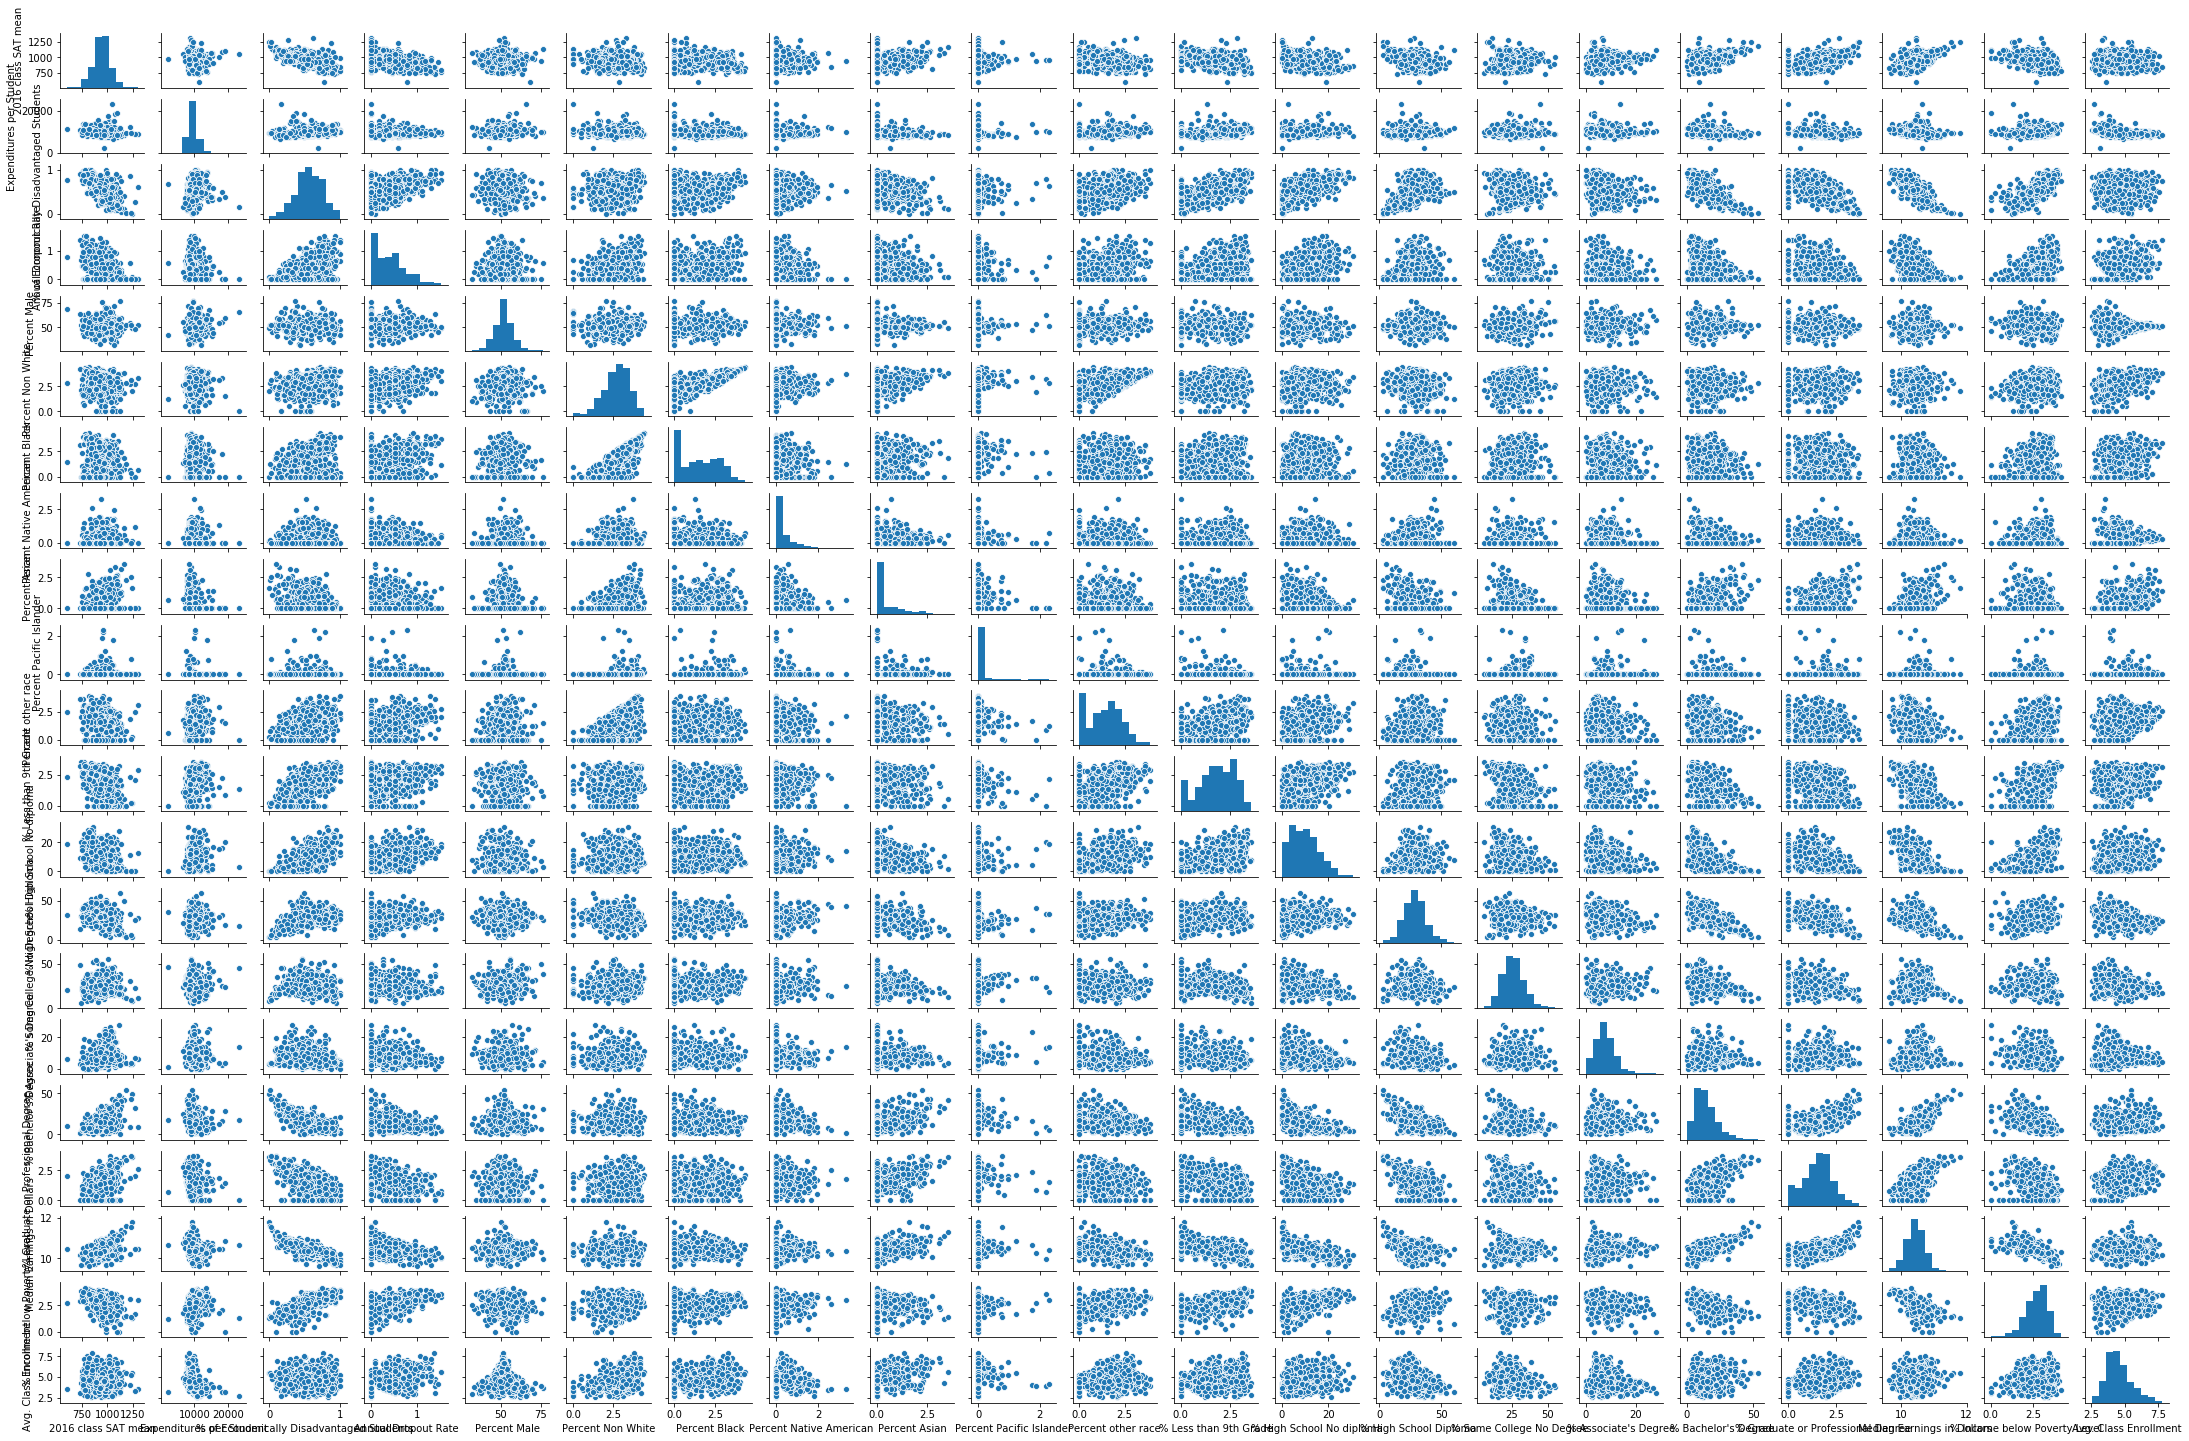

In [173]:
sns.pairplot(sat_analysis_trans_df, height=1.2, aspect=1.5);

In [174]:
#multicolinearity is gone and histograms looking more normal
#sat_analysis_trans_df = sat_analysis_trans_df.reindex()
#sat_analysis_trans_df

### RIDGE

In [175]:
X_4 = sat_analysis_trans_df.iloc[:, 1:]
y_4 = sat_analysis_trans_df['2016 class SAT mean']

#only need 80- 20 split for cross val
X, X_test, y, y_test = \
        train_test_split(X_4, y_4, test_size=0.2, random_state=42)

In [176]:
#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [177]:
#run the CV

#instantiate kfs
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

#for each fold setup train and validate
for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    #fit training data and append score from validation to list
    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.19617898616071483, 0.6212190260026395, 0.48678291836136056, 0.3480771789790282, 0.32622909723731763]
Ridge scores:  [0.19655627040177337, 0.621434861504171, 0.4869806782720848, 0.34889725274339467, 0.32674390365391626] 

Simple mean cv r^2: 0.396 +- 0.146
Ridge mean cv r^2: 0.396 +- 0.146


In [178]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.425


In [179]:
np.where(np.isnan(sat_analysis_trans_df))

(array([], dtype=int64), array([], dtype=int64))

In [180]:
sat_analysis_trans_df.iloc[82, :]

2016 class SAT mean                          1056.000000
Expenditures per Student                    10346.000000
% of Economically Disadvantaged Students        0.441272
Annual Dropout Rate                             0.182322
Percent Male                                   52.500000
Percent Non White                               0.336472
Percent Black                                   0.262364
Percent Native American                         0.000000
Percent Asian                                   0.000000
Percent Pacific Islander                        0.000000
Percent other race                              0.000000
% Less than 9th Grade                           1.824549
% High School No diploma                        5.200000
% High School Diploma                          32.500000
% Some College No Degree                       15.200000
% Associate's Degree                           14.700000
% Bachelor's Degree                            22.000000
% Graduate or Professional Degr

In [181]:
num = sat_df.iloc[136, 12]

np.log(100 - num + 1)

sat_df.iloc[136, 12]

100.0

In [182]:

lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.39963715, 0.45556694, 0.34274145, 0.34908068, 0.33631865])

In [183]:
#random state makes this repeatable
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

#setting cv=kf makes it so you either get the same folds or if you take random_state out, 
#then you can get different folds
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.19617899, 0.62121903, 0.48678292, 0.34807718, 0.3262291 ])

In [184]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.3733444170876627
0.3735376783922688


In [185]:
#presenting to some who are technical and arent technical. Have something for everyone
#i used lasso regression to remedy the overfit and create more stability
# link to a notebook for a particular 

In [187]:
#story...
#idea:  
#data and tools:
#methodology:
#results:
#future: more descriptive variables about students and even to look at students characteristics
#and scores individually

In [256]:
X = sat_analysis_trans_df.iloc[:, 1:]
y = sat_analysis_trans_df["2016 class SAT mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=42)

std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)


lasso_model = LassoCV(cv=5)
lasso_model.fit(X_tr, y_train)
list(zip(X_train.columns, lasso_model.coef_))
test_set_pred = lasso_model.predict(X_te)
r2_score(y_test, test_set_pred)

0.4298066232382588

In [258]:
lasso_model.coef_

array([  0.        , -38.22847141,  -4.09830356,  -0.        ,
        -0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,  -3.46350914,  -0.        ,  -0.        ,
        -0.        ,   0.        ,   0.        ,   6.49205202,
         8.51251041,   0.        ,  -0.        ,  -1.4562283 ])

In [259]:
list(zip(X_train.columns, lasso_model.coef_))

[('Expenditures per Student', 0.0),
 ('% of Economically Disadvantaged Students', -38.22847140641049),
 ('Annual Dropout Rate', -4.098303558078448),
 ('Percent Male', -0.0),
 ('Percent Non White', -0.0),
 ('Percent Black', -0.0),
 ('Percent Native American', 0.0),
 ('Percent Asian', 0.0),
 ('Percent Pacific Islander', 0.0),
 ('Percent other race', -3.463509144533054),
 ('% Less than 9th Grade', -0.0),
 ('% High School No diploma', -0.0),
 ('% High School Diploma', -0.0),
 ('% Some College No Degree', 0.0),
 ("% Associate's Degree", 0.0),
 ("% Bachelor's Degree", 6.492052024171751),
 ('% Graduate or Professional Degree', 8.512510408873153),
 ('Median Earnings in Dollars', 0.0),
 ('% Income below Poverty Level', -0.0),
 ('Avg. Class Enrollment', -1.4562282995784683)]

In [260]:
X = sat_analysis_trans_df.iloc[:, [1,2,9,15,16,19]]
y = sat_analysis_trans_df["2016 class SAT mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=42)

std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)


lasso_model = LassoCV(cv=5)
lasso_model.fit(X_tr, y_train)
list(zip(X_train.columns, lasso_model.coef_))
test_set_pred = lasso_model.predict(X_te)
r2_score(y_test, test_set_pred)

0.4069540075362206

### LASSO

In [241]:
X = sat_analysis_df.iloc[:, 1:]
y = sat_analysis_df["2016 class SAT mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=42)

std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350837.1944510153, tolerance: 400.2770405797102
  positive)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325260.8128899846, tolerance: 400.2770405797102
  positive)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299568.5310367518, tolerance: 400.2770405797102
  positive)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the num

In [232]:
#plot the curve of validation error as alpha changes
#lasso_model.alphas_
#plt.plot(np.log10(lasso_model.alphas_), err_vec_val)

In [242]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_tr, y_train)


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [243]:
lasso_model.alpha_

2.9899351272129127

In [244]:
lasso_model.alphas_

array([45.44435537, 42.38155792, 39.52518276, 36.86131773, 34.37698828,
       32.06009433, 29.89935127, 27.88423507, 26.00493095, 24.25228564,
       22.61776276, 21.09340124, 19.6717766 , 18.34596469, 17.10950808,
       15.95638449, 14.88097758, 13.8780495 , 12.94271541, 12.07041971,
       11.25691382, 10.4982355 ,  9.79068957,  9.13082986,  8.51544249,
        7.94153016,  7.40629761,  6.90713794,  6.44161996,  6.00747633,
        5.60259253,  5.22499655,  4.87284927,  4.54443554,  4.23815579,
        3.95251828,  3.68613177,  3.43769883,  3.20600943,  2.98993513,
        2.78842351,  2.60049309,  2.42522856,  2.26177628,  2.10934012,
        1.96717766,  1.83459647,  1.71095081,  1.59563845,  1.48809776,
        1.38780495,  1.29427154,  1.20704197,  1.12569138,  1.04982355,
        0.97906896,  0.91308299,  0.85154425,  0.79415302,  0.74062976,
        0.69071379,  0.644162  ,  0.60074763,  0.56025925,  0.52249965,
        0.48728493,  0.45444355,  0.42381558,  0.39525183,  0.36

In [245]:
lasso_model.coef_

array([  0.        ,  -4.42868038,  -0.        ,  -9.26115225,
        -0.        ,   0.        ,   0.        ,  -7.78091711,
         0.        ,   0.        ,   0.        ,  -2.29946924,
       -10.41253735,  -6.40966561,  -3.93966398,   0.        ,
         0.        ,   8.17021864,  12.7311838 ,  10.33324981,
        -4.21783529,  -0.        ,  -0.        ])

In [229]:
list(zip(X_train.columns, lasso_model.coef_))

[('Expenditures per Student', 0.0),
 ('Economically Disadvantaged Student Count', -4.428680384427522),
 ('Average Daily Attendance', -0.0),
 ('Annual Dropout Rate', -9.261152249949424),
 ('Percent Male', -0.0),
 ('Percent Female', 0.0),
 ('Percent White', 0.0),
 ('Percent Black', -7.780917111613042),
 ('Percent Native American', 0.0),
 ('Percent Asian', 0.0),
 ('Percent Pacific Islander', 0.0),
 ('Percent other race', -2.299469235528663),
 ('% Less than 9th Grade', -10.412537348558798),
 ('% High School No diploma', -6.409665610994415),
 ('% High School Diploma', -3.9396639818786254),
 ('% Some College No Degree', 0.0),
 ("% Associate's Degree", 0.0),
 ("% Bachelor's Degree", 8.170218639247844),
 ('% Graduate or Professional Degree', 12.731183802789428),
 ('Median Earnings in Dollars', 10.33324980660376),
 ('% Income below Poverty Level', -4.217835289922362),
 ('Student Count', -0.0),
 ('Avg. Class Enrollment', -0.0)]

In [238]:
test_set_pred = lasso_model.predict(X_te)
train_set= lasso_model.predict(X_tr)

In [239]:
r2_score(y_test, test_set_pred)

0.4298066232382588

In [240]:
r2_score(y_train, train_set)

0.42856179823242346

In [252]:
X = sat_analysis_df.iloc[:, [1,2,7,11,12,13,14,17,18,19,20]]
y = sat_analysis_df["2016 class SAT mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=42)

std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [253]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [254]:
lasso_model.alpha_

0.8515442486598533

In [255]:
r2_score(y_train, train_set)

0.42856179823242346

In [ ]:
#look at correlation between funding and parental income